In [233]:
# Initial imports
import pandas as pd
import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing
from sklearn.linear_model import LinearRegression

import wrangle
import explore

import sys
import os
from env import username, api_key, download_kaggle_file

home_directory_path = os.path.expanduser('~')
sys.path.append(home_directory_path +'/utils')

import wrangle_utils as w
import explore_utils as e
import model_utils as m
import env

import warnings
warnings.filterwarnings("ignore")

#
# Wrangle

In [234]:
# Bring in the data
df = wrangle.wrangle_superstore()

In [235]:
# Perform a 70/15/15 split on the dataframe
train, validate, test = wrangle.split_superstore(df)

 Train shape: (6990, 10)
 Validate shape: (1504, 10)
 Test shape (1500, 10)


#
# Explore

## Initial questions:
- What are the highest selling regions?
- What are the highest selling states?
- What are the highest selling segments?
- What are the highest selling categories?

In [236]:
dummies = wrangle.make_dummy_columns(df)
dummies.head()

office_supplies  technology  east  south  west  corporate  \
date                                                                    
2014-01-03                1           0     0      0     0          0   
2014-01-04                1           0     0      0     0          0   
2014-01-04                1           0     0      0     0          0   
2014-01-04                1           0     0      0     0          0   
2014-01-05                1           0     1      0     0          0   

            home_office  
date                     
2014-01-03            0  
2014-01-04            1  
2014-01-04            1  
2014-01-04            1  
2014-01-05            0

In [240]:
# Sort the index for any time manipulation that may be useful later
train.sort_index()

customer_id      segment         state   region       product_id  \
date                                                                          
2014-01-03    DP-13000     Consumer         Texas  Central  OFF-PA-10000174   
2014-01-04    PO-19195  Home Office      Illinois  Central  OFF-LA-10003223   
2014-01-04    PO-19195  Home Office      Illinois  Central  OFF-BI-10004094   
2014-01-05    MB-18085     Consumer  Pennsylvania     East  OFF-AR-10003478   
2014-01-06    JO-15145    Corporate       Georgia    South  OFF-AR-10002399   
...                ...          ...           ...      ...              ...   
2017-12-30    EB-13975    Corporate    California     West  OFF-BI-10002103   
2017-12-30    CC-12430  Home Office       Indiana  Central  OFF-AP-10002457   
2017-12-30    JM-15580     Consumer      Colorado     West  OFF-FA-10003472   
2017-12-30    EB-13975    Corporate    California     West  OFF-BI-10004632   
2017-12-30    PO-18865     Consumer      New York     East  TEC-PH-10004774   

                   category    sales  quantity  discount   profit  
date                                                               
2014-01-03  Office Supplies   16.448         2       0.2   5.5512  
2014-01-04  Office Supplies   11.784         3       0.2   4.2717  
2014-01-04  Office Supplies    3.540         2       0.8  -5.4870  
2014-01-05  Office Supplies   19.536         3       0.2   4.8840  
2014-01-06  Office Supplies   12.780         3       0.0   5.2398  
...                     ...      ...       ...       ...      ...  
2017-12-30  Office Supplies   13.904         2       0.2   4.5188  
2017-12-30  Office Supplies  209.300         2       0.0  56.5110  
2017-12-30  Office Supplies    3.024         3       0.2  -0.6048  
2017-12-30  Office Supplies   20.720         2       0.2   6.4750  
2017-12-30       Technology   90.930         7       0.0   2.7279  

[6990 rows x 10 columns]

### Question 1:
- What are the highest selling regions?

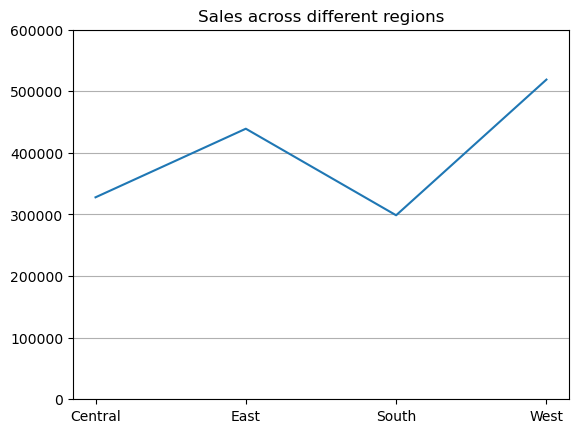

In [250]:
# Plot the sales across different regions
plt.plot(train.groupby('region').sales.agg('sum'))
plt.ylim(0, 600_000);
plt.grid(axis='y')
plt.title('Sales across different regions');

## Observations: 
- The south brings in about half as many sales as the west

### Question 2:
- What are the highest selling segments?

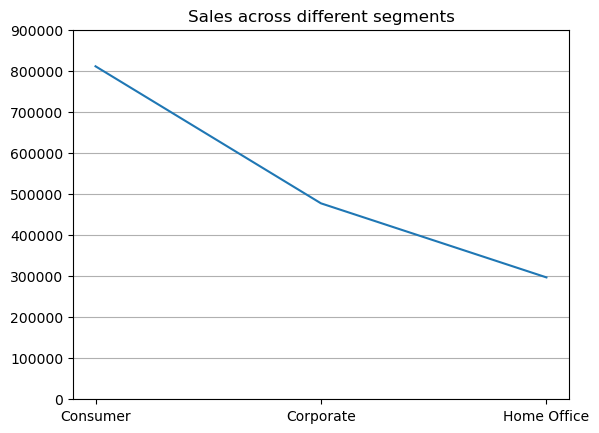

In [249]:
# Plot the sales across different segments
plt.plot(train.groupby('segment').sales.agg('sum'))
plt.ylim(0, 900_000);
plt.grid(axis='y')
plt.title('Sales across different segments');

## Observations: 
- consumer brings in much more (800,000) than corporate (500,000), which brings in more than home office (300,000)

### Question 3:
- What are the highest selling states?

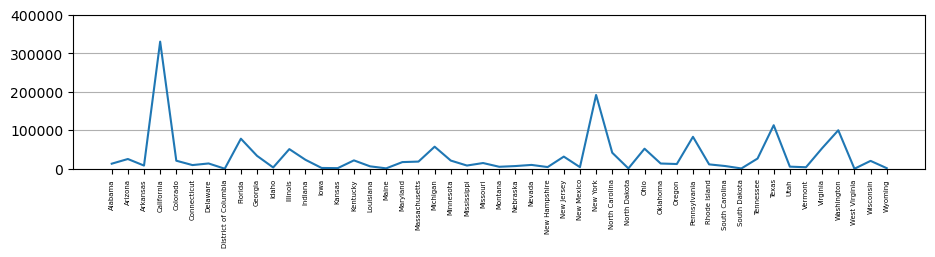

In [243]:
# Plot the sales across different states
plt.figure(figsize=(11,2))
plt.plot(train.groupby('state').sales.agg('sum'))
plt.ylim(0, 400_000)
plt.xticks(fontsize=5,rotation=90);
plt.grid(axis='y')

## Observations: 
- the highest selling states are California (330k), New York (200k), Texas (110k), and Washington (100k)

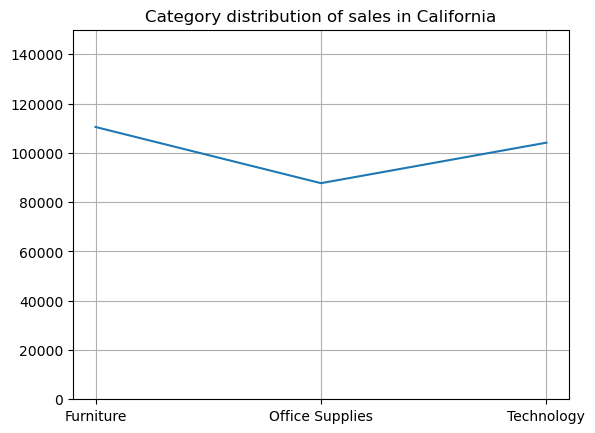

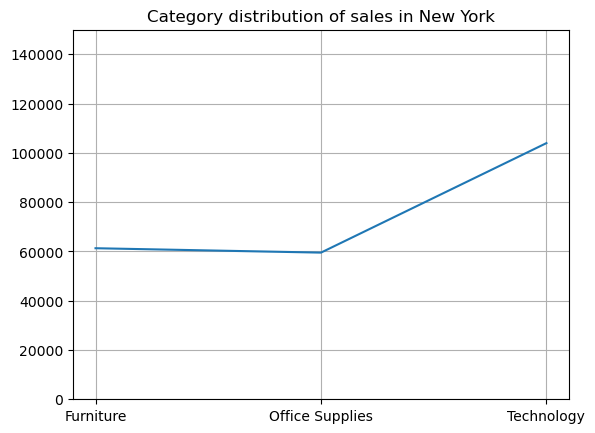

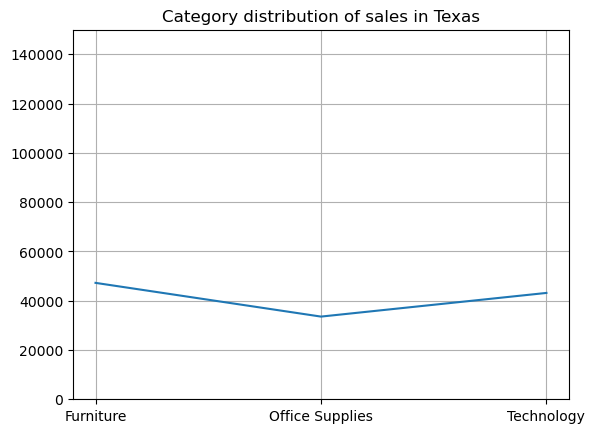

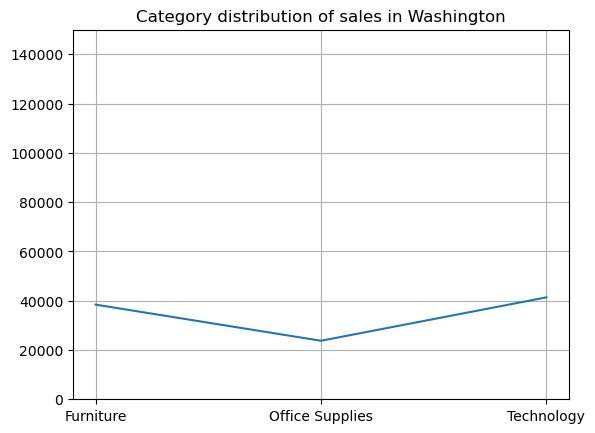

In [103]:
state_list = ['California', 'New York', 'Texas', 'Washington']

# Plot the sales across different states

for state in state_list:     
    state_df = train[train['state'] == state]
    plt.plot(state_df[['category', 'sales']].groupby('category').sales.agg('sum'))
    plt.ylim(0, 150_000)
    plt.grid('y')
    plt.title(f'Category distribution of sales in {state}')
    plt.show()

## Observations:
- Sales across categories in highest selling states:
- California: uniform
- New York: furniture 60k furniture - office supplies 68k - technology 75k
- Texas: furniture 50k furniture - office supplies 30k - technology 50k
- Washington: 35k furniture - office supplies 28k - technology 40k

- New York buys the least in furniture, slightly more in office supplies and the most in technology.
- Texas and Washington buy about the same in furniture and technology around 25% less in office supplies.

- There may be higher competition in the office supplies market in Texas and Washington
- There may be higher competition in the furniture market in New York

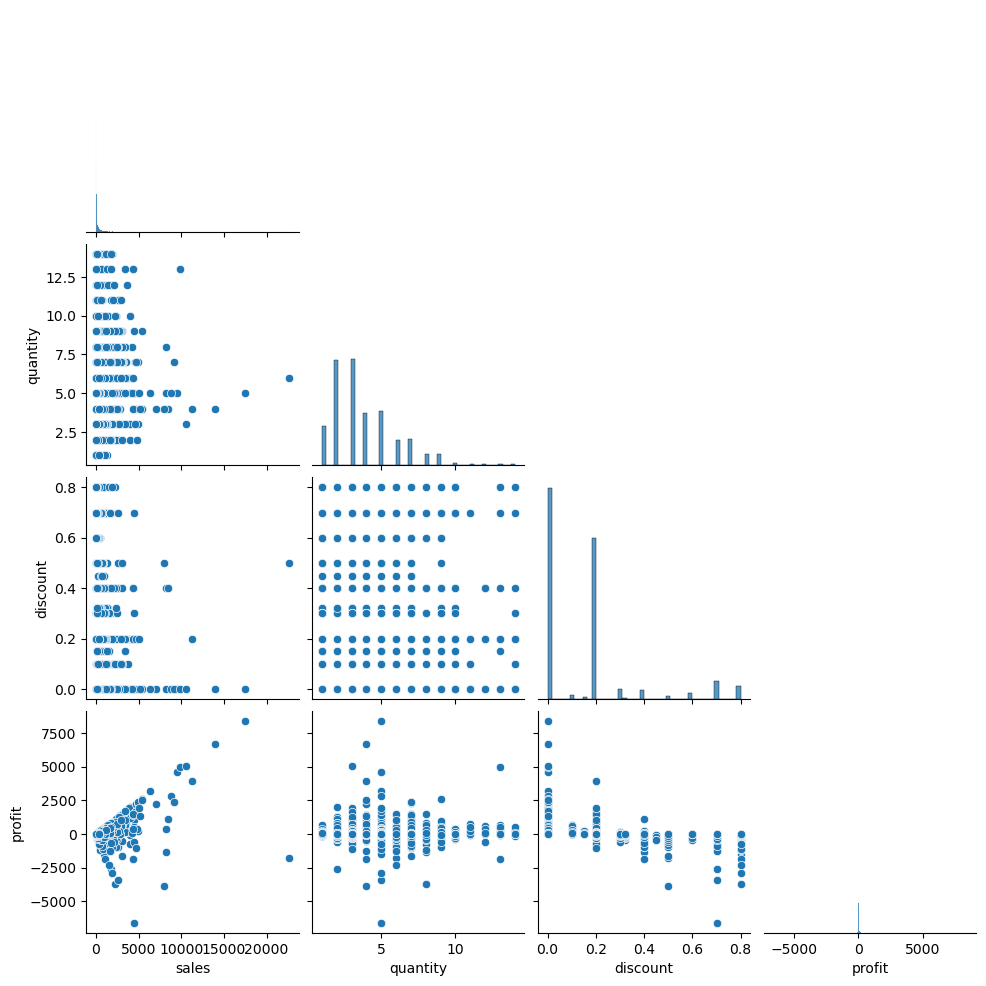

In [18]:
sns.pairplot(df, corner=True)

## Observations:
- As sales increases, profits go up (duh)
- As sales increase, discounts go down
- As discounts increase, profits go down.

In [19]:
test.head()

customer_id      segment        state   region       product_id  \
date                                                                         
2017-09-08    MM-18055     Consumer     Illinois  Central  FUR-TA-10004289   
2017-04-23    PN-18775  Home Office    Tennessee    South  TEC-AC-10002473   
2017-07-09    JF-15190     Consumer  Connecticut     East  OFF-PA-10001497   
2015-12-04    HM-14860    Corporate   California     West  OFF-EN-10003296   
2016-11-10    AF-10885     Consumer         Ohio     East  OFF-ST-10001558   

                   category    sales  quantity  discount    profit  
date                                                                
2017-09-08        Furniture  765.625         7       0.5 -566.5625  
2017-04-23       Technology   45.408         2       0.2   11.9196  
2017-07-09  Office Supplies  274.800         5       0.0  134.6520  
2015-12-04  Office Supplies  271.440         3       0.0  122.1480  
2016-11-10  Office Supplies   38.976         3       0.2   -2.4360

In [20]:
# Resample by day
test = test.resample("D").mean()

In [22]:
test.index.max() - test.index.min()

Timedelta('1456 days 00:00:00')

In [24]:
# Resample the original df by day

df = df.resample("D").sum()
df.head()

sales  quantity  discount     profit
date                                               
2014-01-03    16.448         2       0.2     5.5512
2014-01-04   288.060         8       1.2   -65.9901
2014-01-05    19.536         3       0.2     4.8840
2014-01-06  4407.100        30       0.0  1358.0524
2014-01-07    87.158        10       1.4   -71.9621

In [26]:
df = pd.concat([df, test], axis=1)

In [28]:
train = df

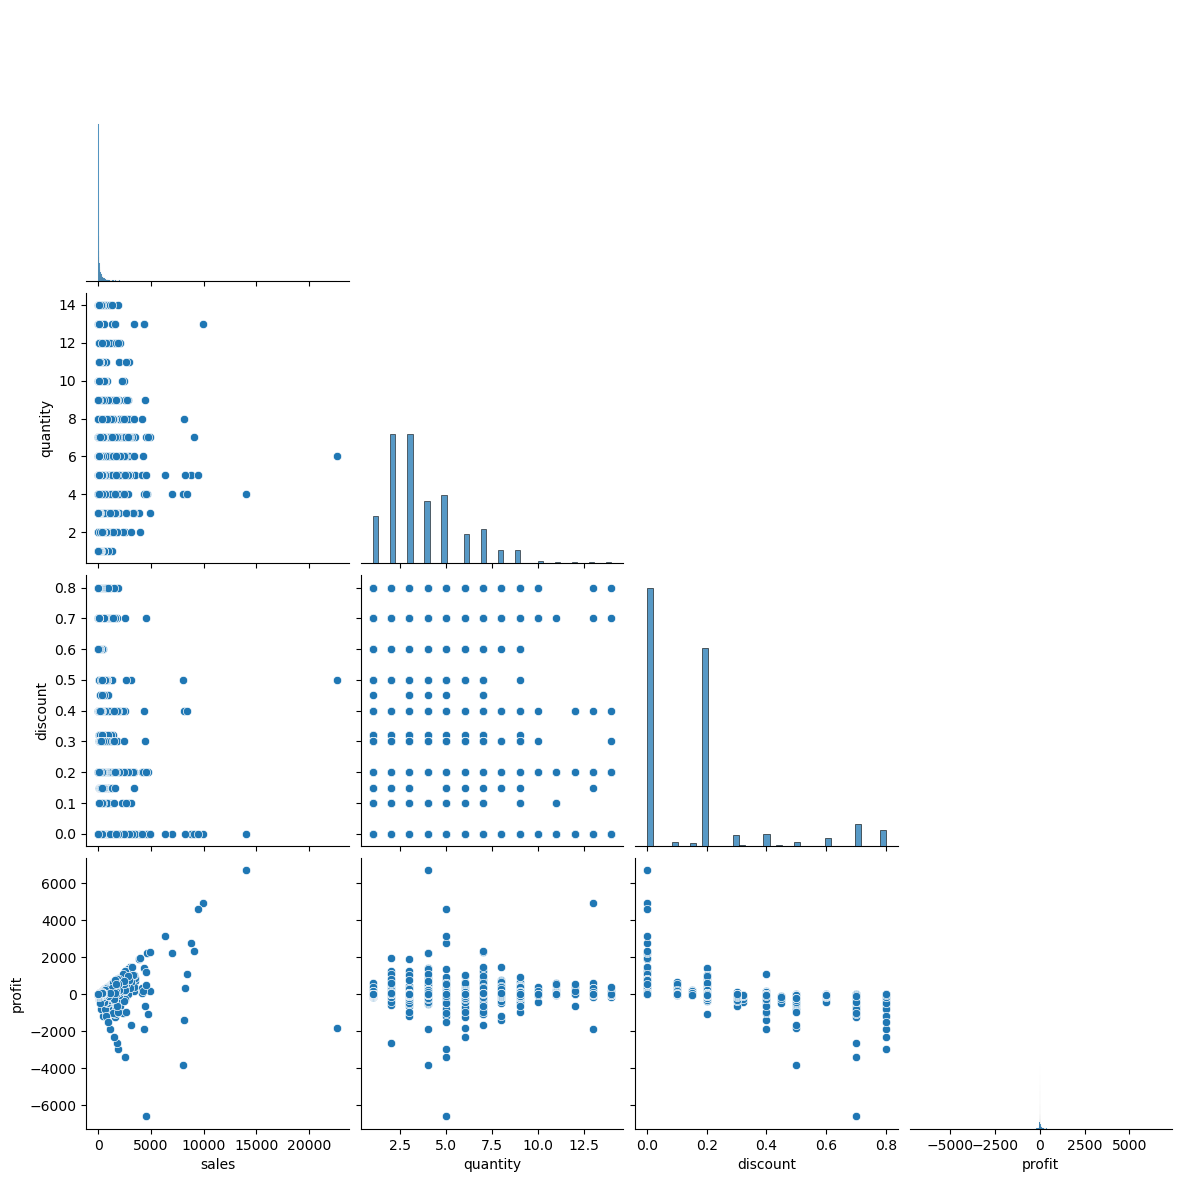

In [251]:
sns.pairplot(train, height=3, corner=True)

In [30]:
# e.explore_bivariate_cont_to_cont_target(train, 'sales')

## Findings: 
- discount and quantity are highly related
- office supplies is related to quantity and discount
- office supplies and sales are related

In [31]:
# category = pd.get_dummies(df.category, drop_first=True)
# region = pd.get_dummies(df.region, drop_first=True)
# segment = pd.get_dummies(df.segment, drop_first=True)
# region = pd.get_dummies(df.region, drop_first=True)

# test = pd.concat([category, region, segment], axis=1)

In [32]:
# frequency_cols = test.resample("W").mean()

In [33]:
# df = pd.concat([df, frequency_cols])
# df= w.normalize_column_names(df)
# df.head()

In [34]:
# test.resample('W').mean()

#
# Time Explore

In [352]:
def time_split_superstore(df, title):
    # Split into train, validate, test (70/15/15)
    # Take measurements
    train_size = int(len(df) * .8)
    validate_size = int(len(df) * .1)
    test_size = int(len(df) - train_size - validate_size)
    validate_end_index = train_size + validate_size

    # split into train, validation, test
    train = pd.DataFrame(df[: train_size])
    validate = pd.DataFrame(df[train_size : validate_end_index])
    test = pd.DataFrame(df[validate_end_index : ])
    
    print(f'''
train length: {train.shape[0]}
validate length: {validate.shape[0]}
test length: {test.shape[0]}
    ''')
    
    # Plot the dataframes
    plt.plot(train.index, train.sales)
    plt.plot(validate.index, validate.sales)
    plt.plot(test.index, test.sales)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.show()
    
    return train, validate, test

## Project One: Explore overall autocorrelation

In [331]:
df = wrangle.wrangle_superstore()

In [332]:
df.shape

(9994, 10)

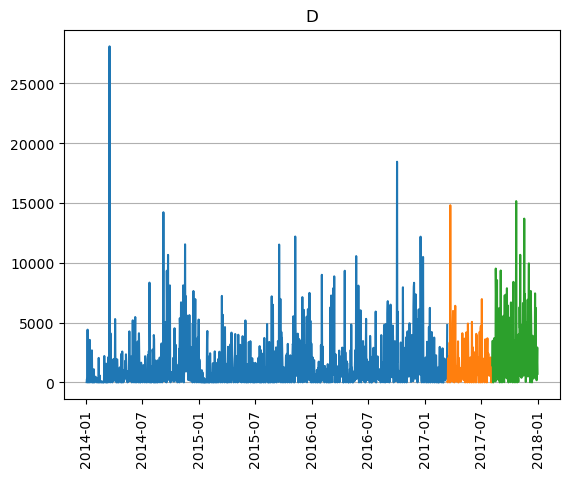

ValueError: too many values to unpack (expected 2)

In [333]:
timescales = ['D', 'W', 'M']    
for scale in timescales:
    df_resampled = pd.DataFrame(df.resample(scale).sales.agg('sum'))
    train, test = time_split_superstore(df_resampled, scale)
    pd.plotting.autocorrelation_plot(train.sales)
    plt.show()

## Observations:
- A daily sampled model may be viable for overall sales using a lag of around 45 as well as 365
- A weekly sampled model may be viable for overall sales using a lag of around 52 as well as 110
- A monthly sampled model may be viable for overall sales using a lag of around 13 as well as 24

### Handle outliers

In [285]:
daily_df = pd.DataFrame(df.resample('D').sales.agg('sum'))

<Axes: xlabel='date'>

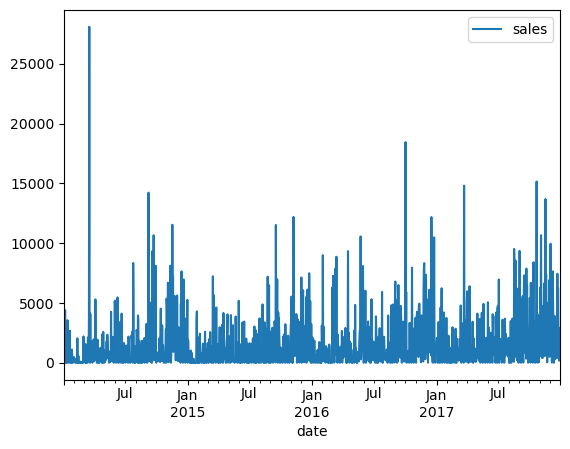

In [286]:
daily_df.plot()

In [ ]:
# Outliers list
# 2014-03-18 -> 10_000
# 2016-10-02 -> 11_000
# 2017-10-22 -> 14_000
# 2017-03-23 -> 6_000

In [288]:
daily_df.sort_values('sales', ascending=False).head(10)

sales
date                  
2014-03-18  28106.7160
2016-10-02  18452.9720
2017-10-22  15158.8770
2017-03-23  14816.0680
2014-09-08  14228.4280
2017-11-17  13694.8828
2015-11-08  12196.9970
2016-12-17  12185.1340
2014-11-17  11544.2740
2015-09-17  11525.0060

### Now handle the outliers, once done put the handling code in the wrangle

In [295]:
daily_df.loc[pd.to_datetime('2014-03-18')][0] = 10_000
daily_df.loc[pd.to_datetime('2016-10-02')][0] = 11_000
daily_df.loc[pd.to_datetime('2017-10-22')][0] = 14_000
daily_df.loc[pd.to_datetime('2017-03-23')][0] = 6_000
daily_df.loc[pd.to_datetime('2014-09-08')][0] = 10_000

## Write a wrangle function to handle these outliers

In [338]:
def overall_time_wrangle():    
    df = wrangle.wrangle_superstore()

    #df_resampled = df[df.state == 'New York']

    df = pd.DataFrame(df.resample("D").sales.agg('sum'))
    
    df.loc[pd.to_datetime('2014-03-18')][0] = 10_000
    df.loc[pd.to_datetime('2016-10-02')][0] = 11_000
    df.loc[pd.to_datetime('2017-10-22')][0] = 14_000
    df.loc[pd.to_datetime('2017-03-23')][0] = 6_000
    df.loc[pd.to_datetime('2014-09-08')][0] = 10_000
    
#     df_resampled['lag_53'] = df_resampled.sales.shift(53)
#     df_resampled = df_resampled.dropna()
    
    return df

In [353]:
df = overall_time_wrangle()


train length: 1166
validate length: 145
test length: 147
    


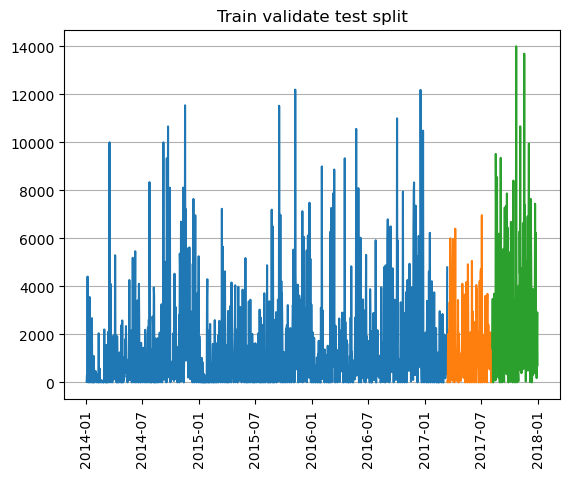

In [354]:
train, validate, test = time_split_superstore(df, 'Train validate test split')


train length: 1166
validate length: 145
test length: 147
    


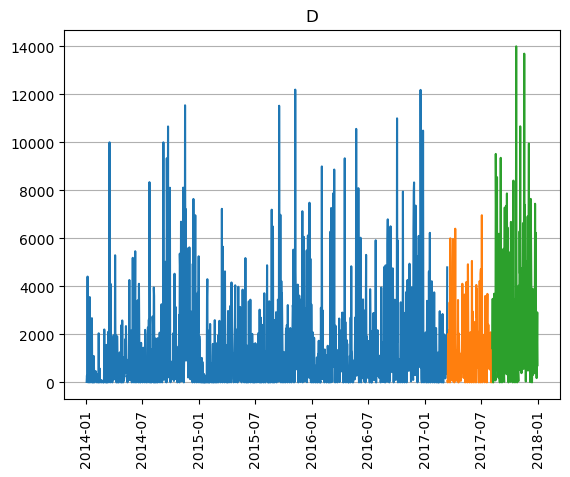

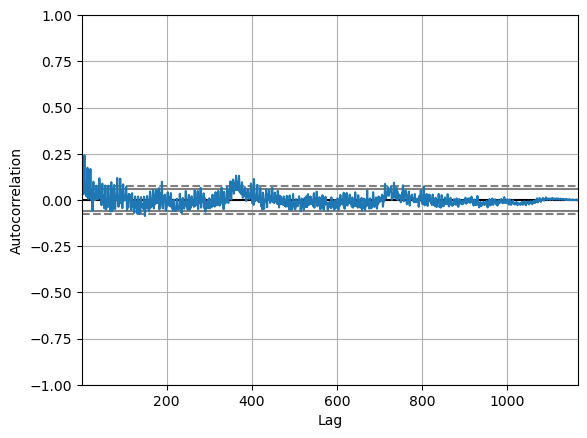


train length: 167
validate length: 20
test length: 22
    


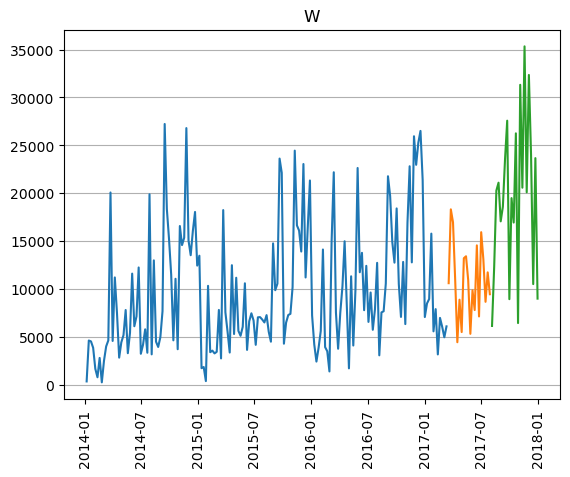

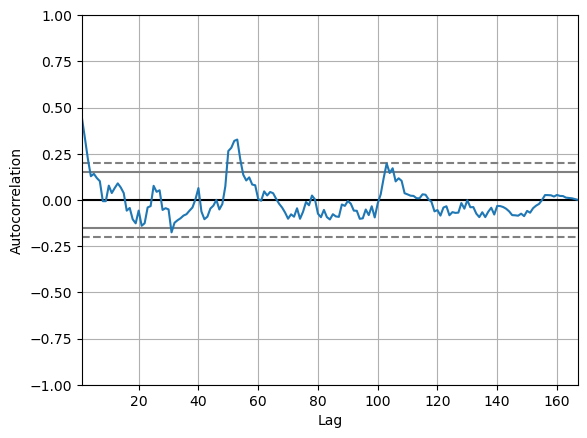


train length: 38
validate length: 4
test length: 6
    


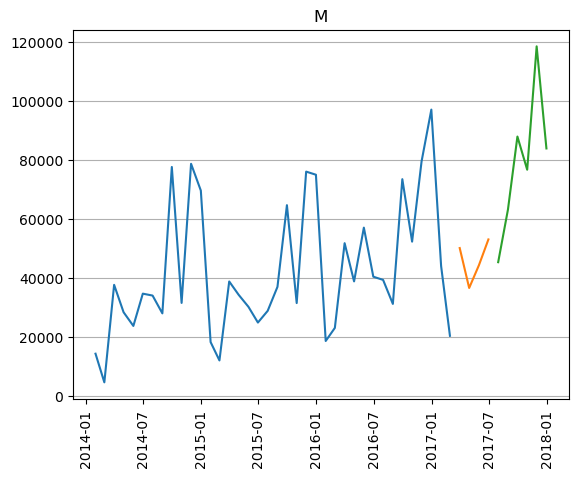

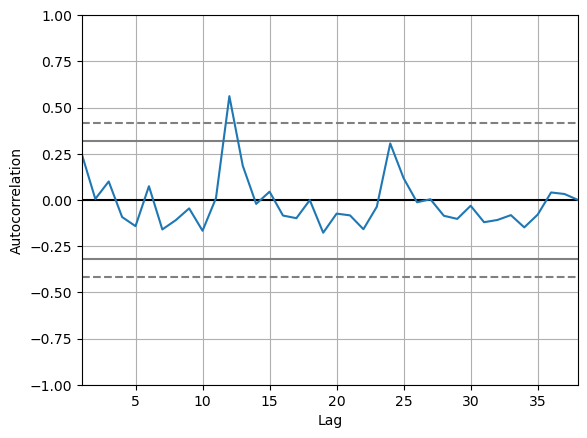

In [355]:
timescales = ['D', 'W', 'M']    
for scale in timescales:
    df_resampled = pd.DataFrame(df.resample(scale).sales.agg('sum'))
    train, validate, test = time_split_superstore(df_resampled, scale)
    pd.plotting.autocorrelation_plot(train.sales)
    plt.show()

## Observations:
- Weekly sampling provides a good balance of training data and a high degree of seasonality so it will be used for the MVP
- Try making columns around 1 and 52 lag

## Stats testing for outliers


train length: 167
validate length: 20
test length: 22
    


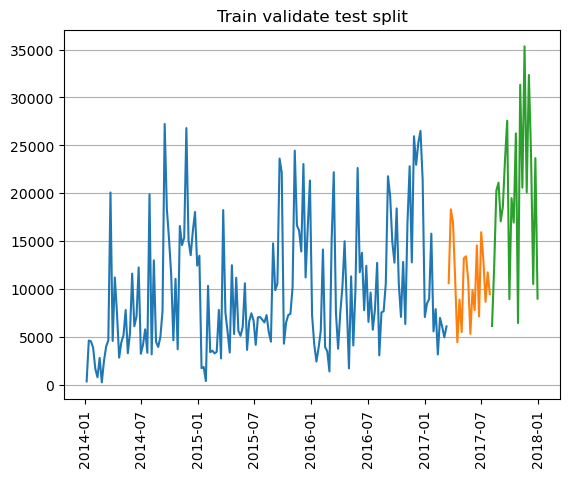

In [357]:
df = overall_time_wrangle()
df = df.resample("W").sales.agg("sum")
train, validate, test = time_split_superstore(df, 'Train validate test split')

In [358]:
# Stats test the days around 1 day ago for autocorrelation

results_list = []

for i in range(0, 5):
    pearson = train.copy()  # Make a copy of 'train' DataFrame
    pearson[f'lag_{i}'] = pearson.sales.shift(i)
    pearson = pearson.dropna()
    r, p = pearsonr(pearson.sales, pearson[f'lag_{i}'])
    results_list.append({
        'lag': i,
        'R value': r,
        'P-value': p
    })

results_df = pd.DataFrame(results_list)
display(results_df)


lag   R value       P-value
0    0  1.000000  0.000000e+00
1    1  0.447241  1.533507e-09
2    2  0.338653  8.619536e-06
3    3  0.224547  3.844809e-03
4    4  0.130087  9.790383e-02

## Observations:
- A lag of one week predicts current sales very well

In [359]:
# Stats test the days around 52 days ago for autocorrelation

results_list = []

for i in range(50, 56):
    pearson = train.copy()  # Make a copy of 'train' DataFrame
    pearson[f'lag_{i}'] = pearson.sales.shift(i)
    pearson = pearson.dropna()
    r, p = pearsonr(pearson.sales, pearson[f'lag_{i}'])
    results_list.append({
        'lag': i,
        'R value': r,
        'P-value': p
    })

results_df = pd.DataFrame(results_list)
display(results_df)

lag   R value       P-value
0   50  0.406135  5.539428e-06
1   51  0.434166  1.120634e-06
2   52  0.490521  2.623117e-08
3   53  0.512254  5.683080e-09
4   54  0.354035  1.195912e-04
5   55  0.228185  1.552893e-02

## Observations:
- A lag of fifty-three weeks predicts current sales very well

## Create the lag dataframes

In [369]:
df = overall_time_wrangle()
df = pd.DataFrame(df.resample("W").sales.agg("sum"))

In [371]:
# Create and append a column with a lag of 53 weeks to the train dataframe and drop the nulls
df['lag_1'] = df.sales.shift(1)
df['lag_53'] = df.sales.shift(53)
df = df.dropna()


train length: 124
validate length: 15
test length: 17
    


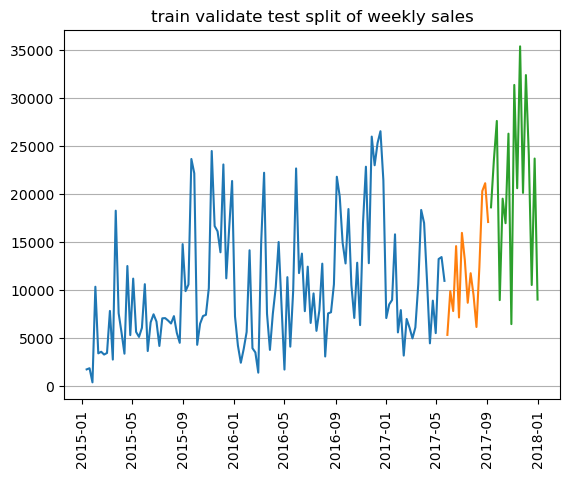

sales       lag_1     lag_53
date                                         
2015-01-11   1708.9840  13462.7946    324.044
2015-01-18   1827.2760   1708.9840   4599.572
2015-01-25    358.5220   1827.2760   4509.127
2015-02-01  10314.5160    358.5220   3842.388
2015-02-08   3378.5820  10314.5160   1642.310
...                ...         ...        ...
2017-04-23   8866.1770   4420.5160  14973.249
2017-04-30   5483.5366   8866.1770   8293.219
2017-05-07  13201.1918   5483.5366   1689.812
2017-05-14  13405.0690  13201.1918  11311.609
2017-05-21  10927.5760  13405.0690   4076.232

[124 rows x 3 columns]

In [381]:
train, validate, test = time_split_superstore(df, 'train validate test split of weekly sales')
train

In [446]:
# Perform an x-y split
# X_train, y_train = train[['lag_1', 'lag_53']], train[['sales']]
# X_validate, y_validate = validate[['lag_1', 'lag_53']], validate[['sales']]
# X_test, y_test = test[['lag_1', 'lag_53']], test[['sales']]

X_train, y_train = train[['lag_53']], train[['sales']]
X_validate, y_validate = validate[['lag_53']], validate[['sales']]
X_test, y_test = test[['lag_53']], test[['sales']]

## Build baseline models

In [447]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var])**.5 ), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    return rmse


# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])


### Last Observed Value Model

sales -- RMSE: 4908


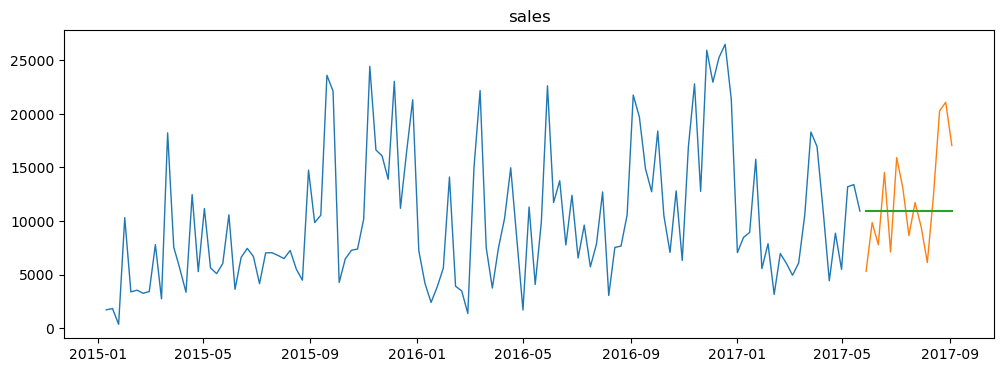

In [448]:
# take the last item of sales total and assign to variable
last_sale = y_train.tail(1).sales[0]

yhat_df = pd.DataFrame(
    {'sales': [last_sale]},
    index=validate.index)

# Plot the last observed model value
for col in y_train.columns:
    rmse = plot_and_eval(col)
    
rmse_df = pd.DataFrame({
    'model': 'LastObserved',
    'rmse' : round(rmse)
}, index=[0])

### Simple Average model

sales -- RMSE: 5143


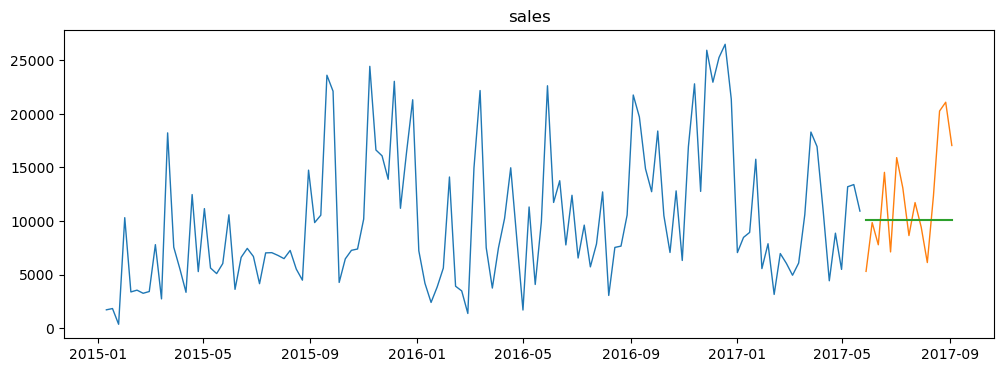

In [449]:
# compute simple average of sales_total (from train data)
avg_sales = round(y_train.sales.mean(), 2)

yhat_df = pd.DataFrame({'sales': [avg_sales]},
                        index=validate.index)

for col in y_train.columns:
    rmse = plot_and_eval(col)
    
rmse_df = rmse_df.append({
    'model': 'SimpleAverage',
    'rmse' : round(rmse)
}, ignore_index=True)

### Rolling average

Period = 40 weeks

sales -- RMSE: 4844


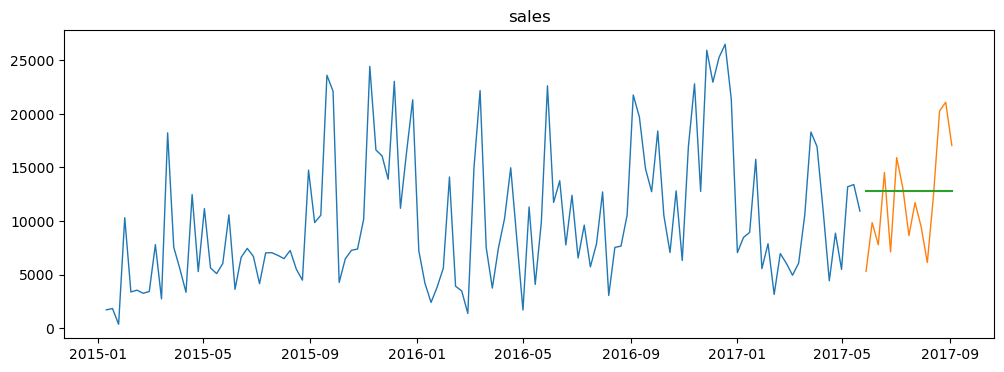

Period = 41 weeks

sales -- RMSE: 4826


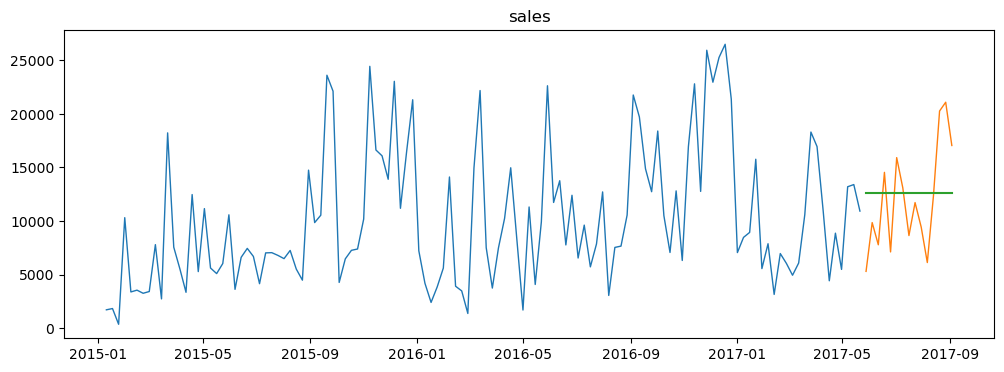

Period = 42 weeks

sales -- RMSE: 4802


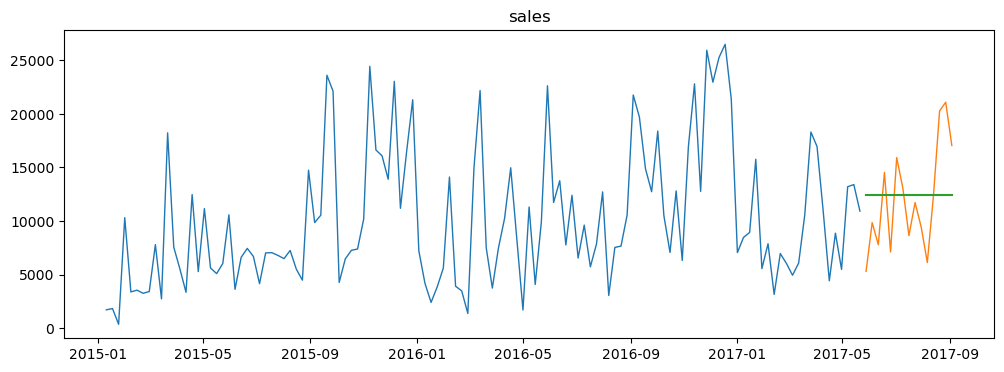

Period = 43 weeks

sales -- RMSE: 4802


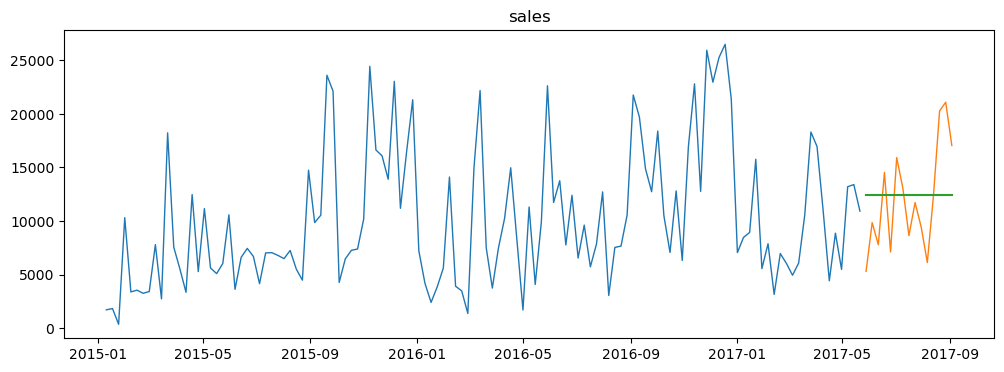

Period = 44 weeks

sales -- RMSE: 4794


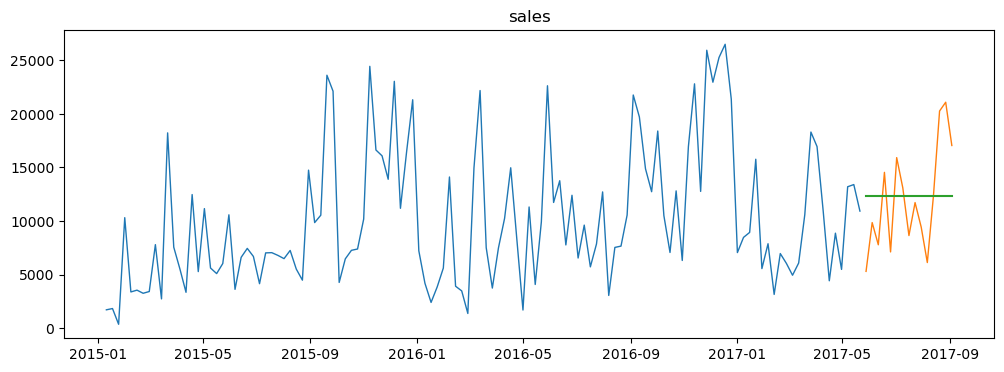

Period = 45 weeks

sales -- RMSE: 4788


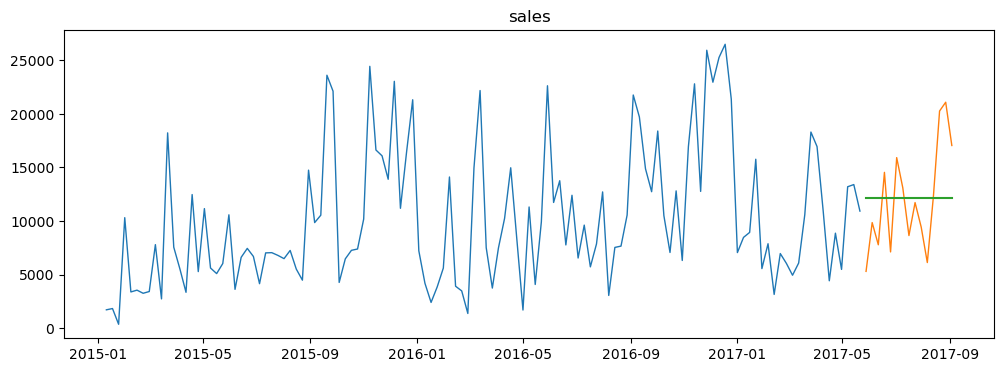

Period = 46 weeks

sales -- RMSE: 4786


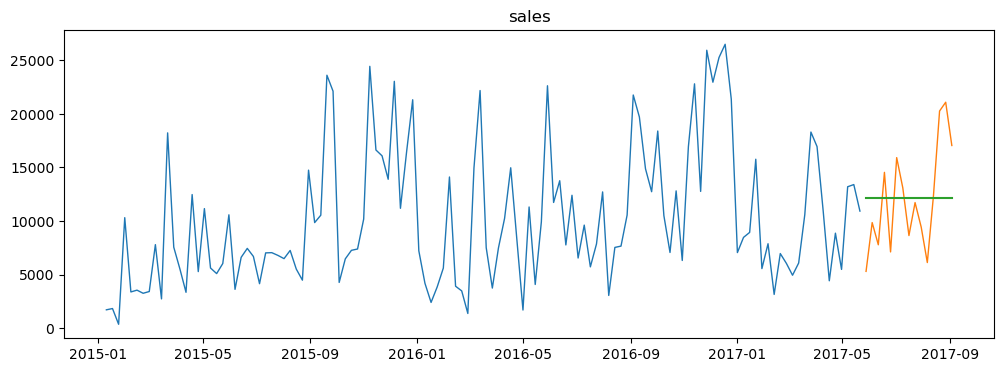

Period = 47 weeks

sales -- RMSE: 4785


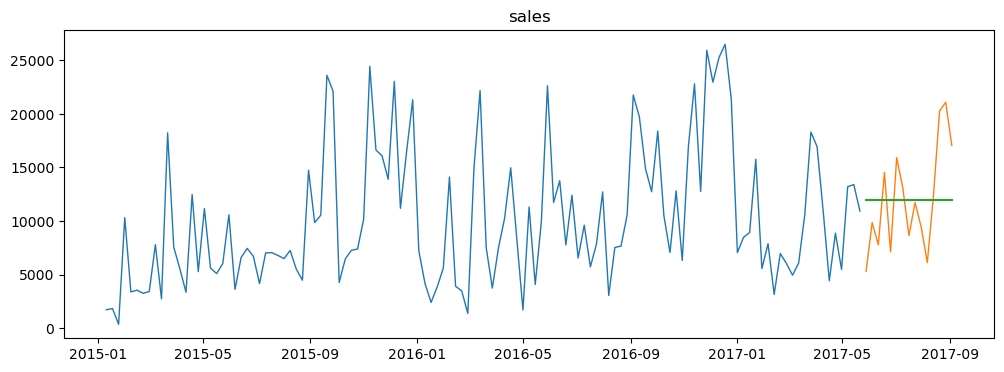

Period = 48 weeks

sales -- RMSE: 4785


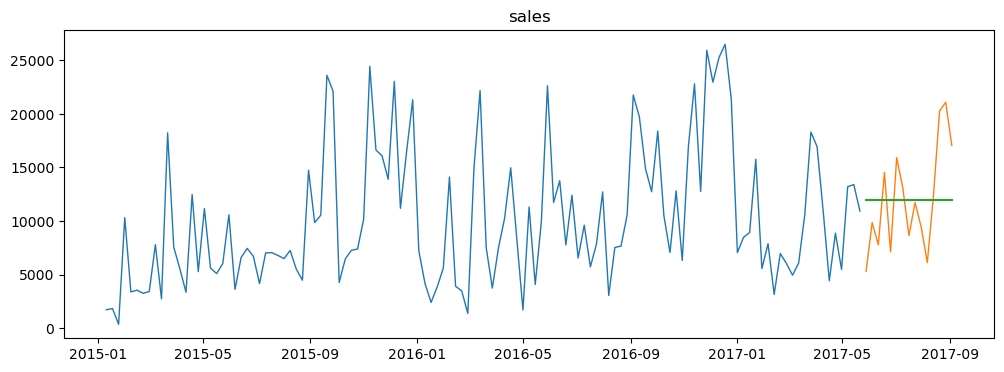

Period = 49 weeks

sales -- RMSE: 4786


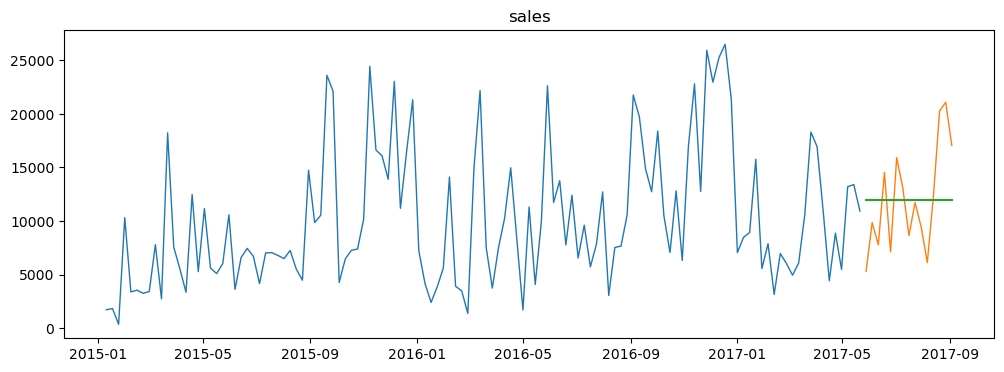

Period = 50 weeks

sales -- RMSE: 4785


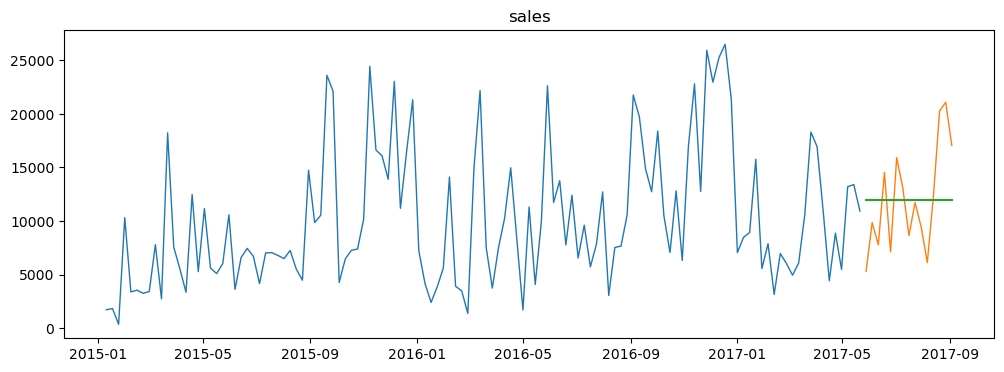

Period = 51 weeks

sales -- RMSE: 4785


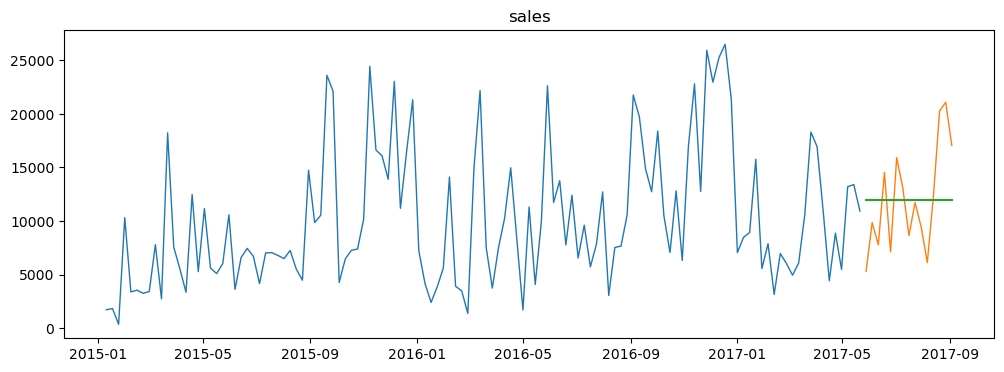

Period = 52 weeks

sales -- RMSE: 4787


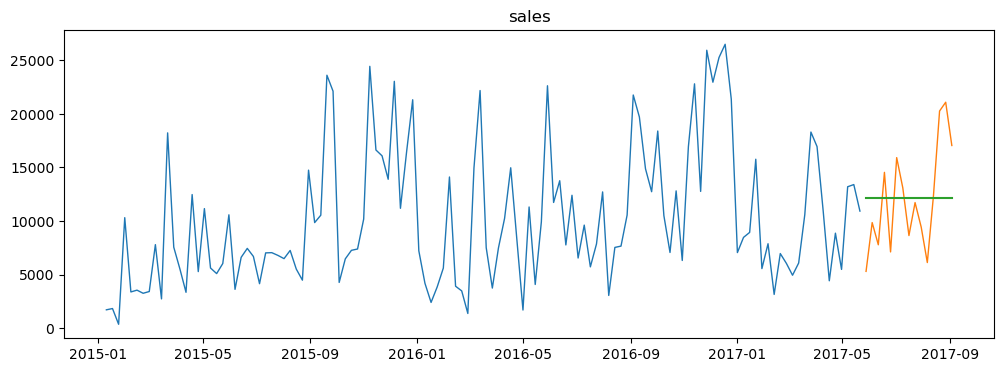

Period = 53 weeks

sales -- RMSE: 4786


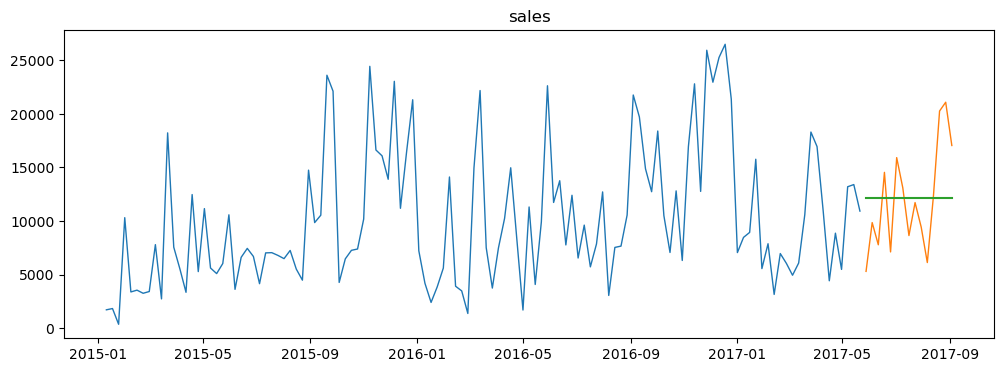

Period = 54 weeks

sales -- RMSE: 4785


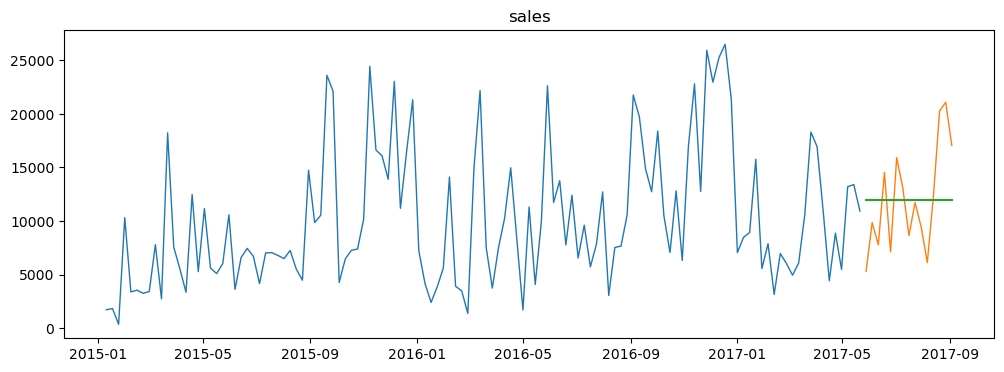

Period = 55 weeks

sales -- RMSE: 4785


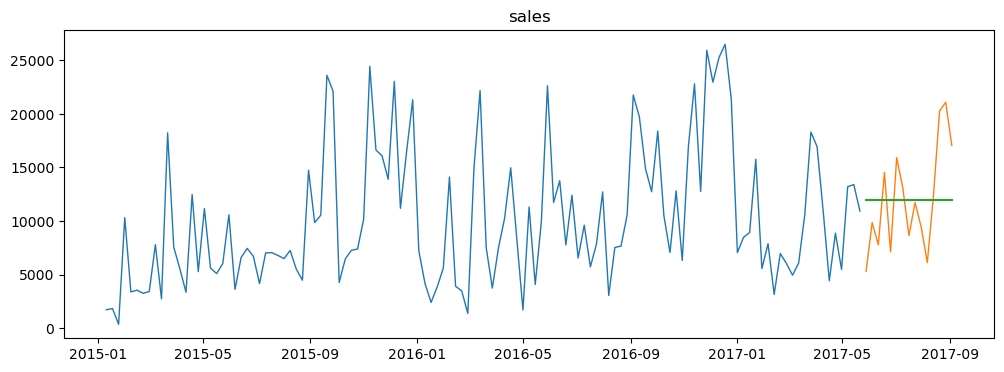

In [450]:
# compute a weekly rolling average, 
# use the most recent/last 30 weekly period value to predict forward. 

for i in range(40,56):
    period = i

    rolling_sales = round(train['sales'].rolling(period).mean()[-1], 2)

    # yhat_df = make_predictions()

    yhat_df = pd.DataFrame({'sales': rolling_sales},
                             index=validate.index)
    # Plot 30 week rolling average

    for col in train[['sales']].columns:
        print(f'Period = {period} weeks\n')
        rmse = plot_and_eval(col)
        rmse_df = rmse_df.append({
        'model': f'RollingAverage_{i}',
        'rmse' : round(rmse)
        }, ignore_index=True)

In [451]:
rmse_df[rmse_df.rmse == rmse_df.rmse.min()]

model  rmse
9   RollingAverage_47  4785
10  RollingAverage_48  4785
12  RollingAverage_50  4785
13  RollingAverage_51  4785
16  RollingAverage_54  4785
17  RollingAverage_55  4785

In [452]:
rmse_df

model  rmse
0        LastObserved  4908
1       SimpleAverage  5143
2   RollingAverage_40  4844
3   RollingAverage_41  4826
4   RollingAverage_42  4802
5   RollingAverage_43  4802
6   RollingAverage_44  4794
7   RollingAverage_45  4788
8   RollingAverage_46  4786
9   RollingAverage_47  4785
10  RollingAverage_48  4785
11  RollingAverage_49  4786
12  RollingAverage_50  4785
13  RollingAverage_51  4785
14  RollingAverage_52  4787
15  RollingAverage_53  4786
16  RollingAverage_54  4785
17  RollingAverage_55  4785

### Observations:
- Rolling average with a lag of 47 is the first occuring model with the lowest RMSE value
- This model is also the best performing baseline model overall

### Next Steps:
- build non-baseline models

### Holt's Linear model

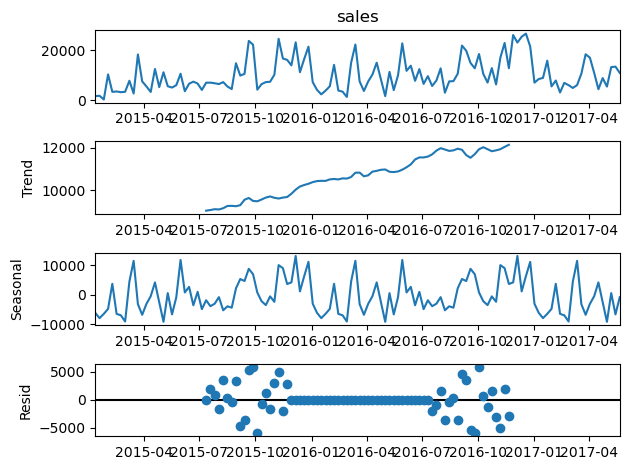

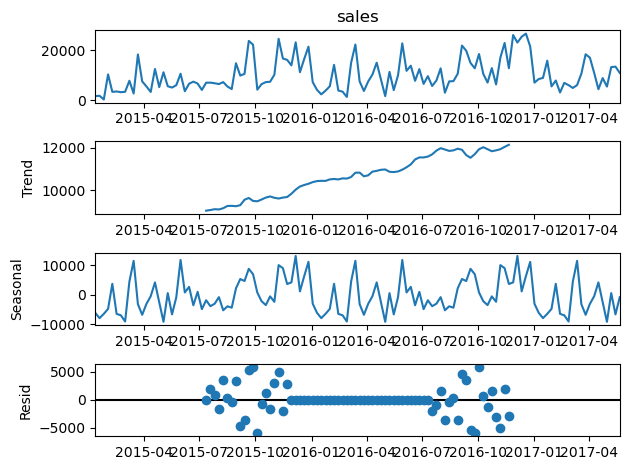

In [469]:
# Resample 'train' to weekly data and calculate the mean
weekly_mean = y_train.sales.resample('W').mean()

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(weekly_mean)

# Plot each component separately
decomposition.plot()

sales -- RMSE: 4493


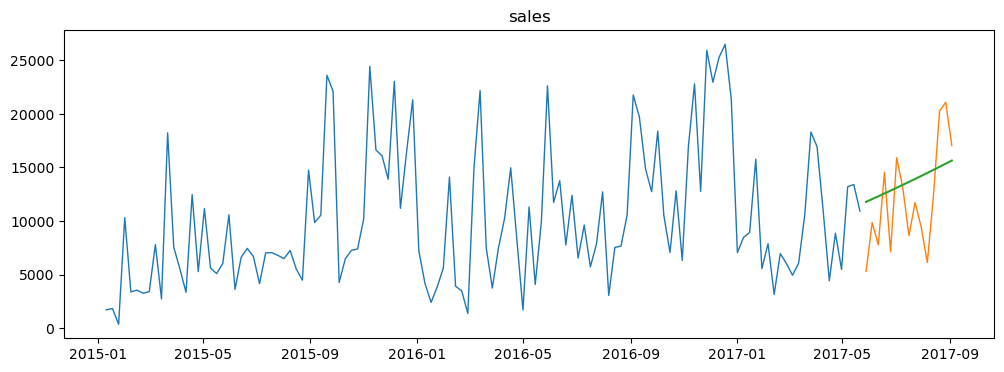

In [501]:
for col in train.columns:
    model = Holt(train[col], exponential=True, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


for col in train[['sales']].columns:
    rmse = plot_and_eval(target_var = col)
    
results_df = pd.DataFrame({
'model': 'HoltsLinear',
'rmse' : round(rmse)
}, index=[0])

In [483]:
results_df

model  rmse
0  HoltsLinear  4493

## Observations:
- Holt's Linear Model outperformed the baseline

### Holt's Seasonal Model

In [484]:
# Make/fit the models for sales
hst_sales_fit1 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='add').fit()
hst_sales_fit2 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='mul').fit()
hst_sales_fit3 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='add', damped=True).fit()
hst_sales_fit4 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='mul', damped=True).fit()

results_sales=pd.DataFrame({'model':['hst_sales_fit1', 'hst_sales_fit2', 'hst_sales_fit3', 'hst_sales_fit4'],
                              'SSE':[hst_sales_fit1.sse, hst_sales_fit2.sse, hst_sales_fit3.sse, hst_sales_fit4.sse]})
results_sales.sort_values(by='SSE')


model           SSE
2  hst_sales_fit3  3.261883e+09
0  hst_sales_fit1  3.277708e+09
3  hst_sales_fit4  3.553777e+09
1  hst_sales_fit2  3.953398e+09

### Observations:
- hst_sales_fit3 performed the best and will be used

sales -- RMSE: 7221


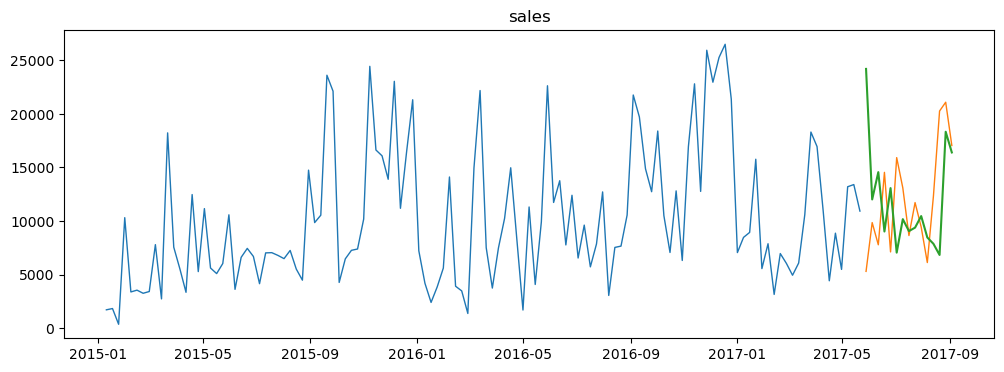

In [485]:
yhat_df = pd.DataFrame({'sales': hst_sales_fit4.forecast(validate.shape[0] + 1)},
                          index=validate.index)

for col in train[['sales']].columns:
    rmse = plot_and_eval(col)

results_df = results_df.append({
    'model': 'HoltsSeasonal_fit3',
    'rmse' : round(rmse)    
}, ignore_index=True)

In [486]:
results_df

model  rmse
0         HoltsLinear  4493
1  HoltsSeasonal_fit3  7221

### Observations:
- Holts Seasonal model did not outperform the baseline

## Linear Regression Model

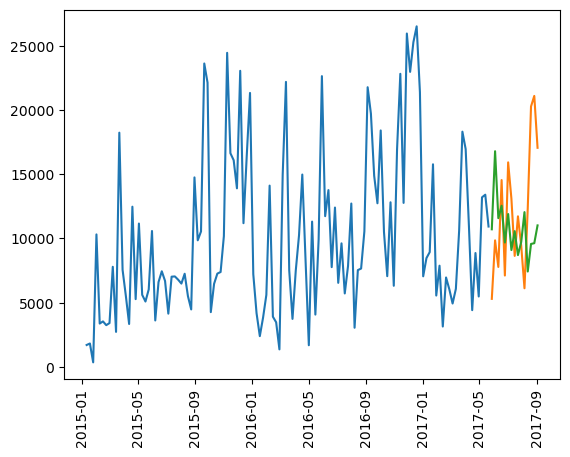

In [487]:
# Make the thing
model = LinearRegression()

# Fit the thing
ny_model = model.fit(X_train, y_train)

# Make Predictions
y_hat_val = ny_model.predict(X_validate)
y_hat_val = pd.DataFrame(y_hat_val)

# Set the index
y_hat_val.index = validate.index

# Graph predictions
plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(y_hat_val)
plt.xticks(rotation=90);

# Collect the RMSE and append it to the results_df
rmse = mean_squared_error(y_validate, ny_model.predict(X_validate))**.5

results_df = results_df.append({
    'model': 'LinearRegression',
    'rmse' : round(rmse)    
}, ignore_index=True)

In [488]:
results_df

model  rmse
0         HoltsLinear  4493
1  HoltsSeasonal_fit3  7221
2    LinearRegression  5710

In [489]:
rmse_df.sort_values('rmse').head()

model  rmse
17  RollingAverage_55  4785
13  RollingAverage_51  4785
12  RollingAverage_50  4785
10  RollingAverage_48  4785
9   RollingAverage_47  4785

In [491]:
4785 - 4493

292

## Observations:
- Holt's Linear Model beat the baseline by 292 sales
- The rmse was not effected by including the one week lag

## Predict on the test data

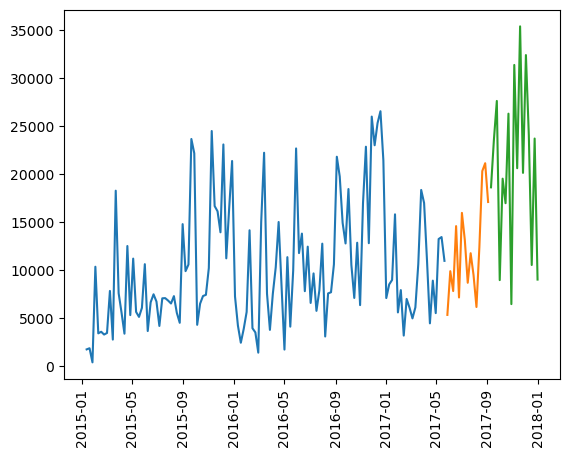

In [529]:
plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(test.sales)
plt.plot(yhat_df.sales)
plt.xticks(rotation=90)
    
results_df = pd.DataFrame({
'model': 'HoltsLinear_test',
'rmse' : round(rmse)
}, index=[0])

## Explore autocorrelation based on states

Scanning for autocorrelation on a monthly timescale

For California


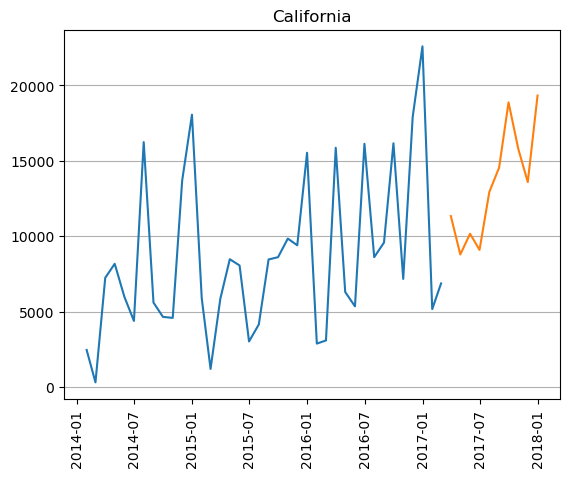

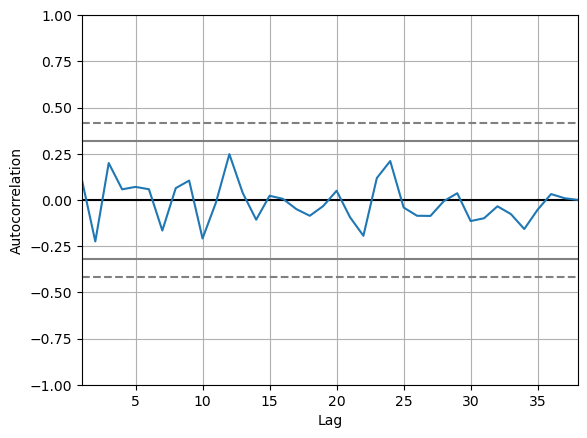

For New York


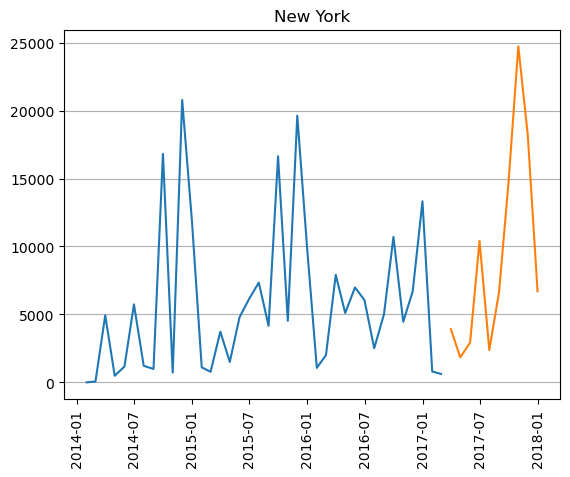

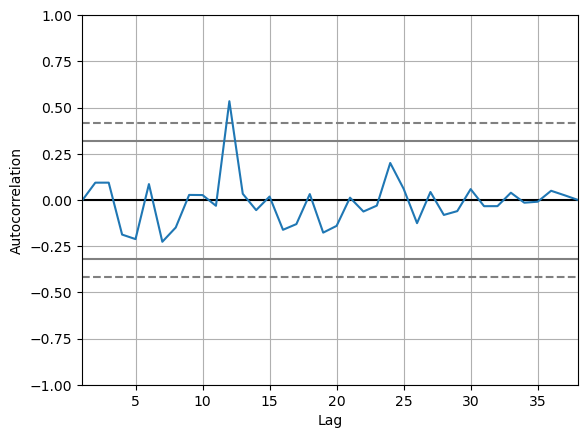

For Texas


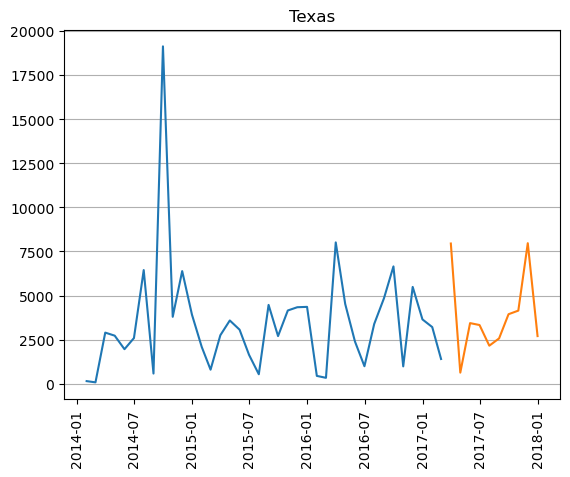

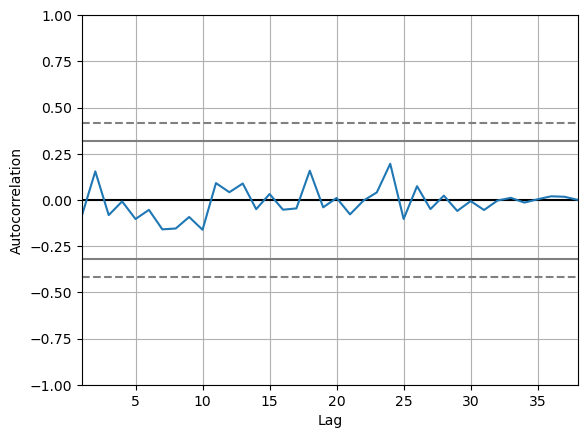

For Washington


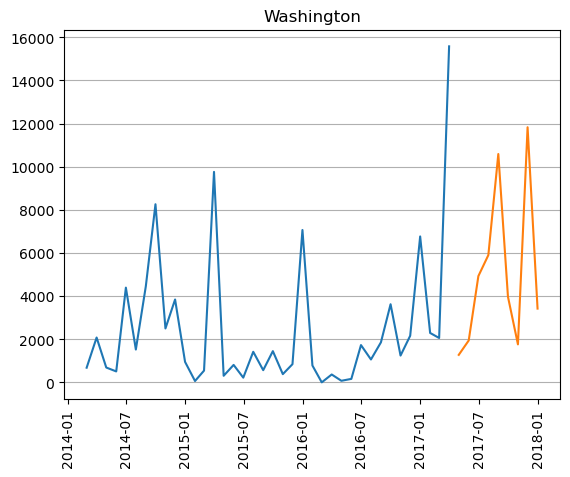

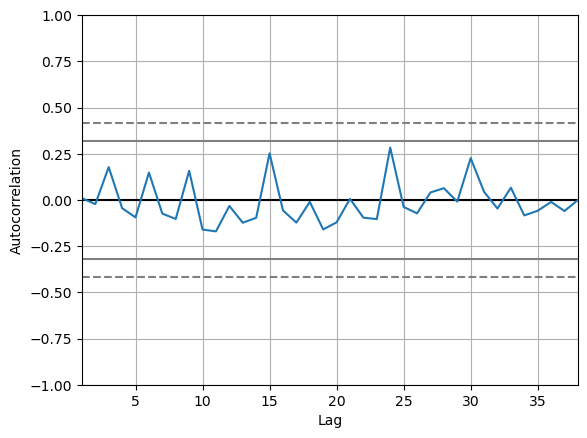

In [270]:
states_list = ['California', 'New York', 'Texas', 'Washington']
print('Scanning for autocorrelation on a monthly timescale\n')

for state in states_list:    
    state= state
    print(f'For {state}')
    df = wrangle.wrangle_superstore()
    df = df[df.state== state]
    df = pd.DataFrame(df.resample('M').sales.agg('sum'))
    train, test = time_split_superstore(df, state)
    pd.plotting.autocorrelation_plot(train.sales)
    plt.show()

## Observations:
- California shows no significant autocorrelation on a monthly timescale
- New York shows clear seasonality and good autocorrelation on a monthly timescale
- Texas may show some seasonality after outliers are removed but its autocorrelation is very weak on a monthly timescale
- Washington has a slight degree of seasonality on this time scale and may be good enough to build a model off of once outliers are removed

Scanning for autocorrelation on a weekly timescale

For California


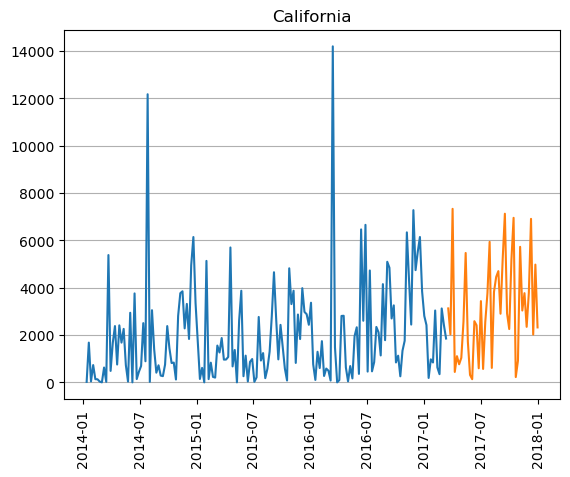

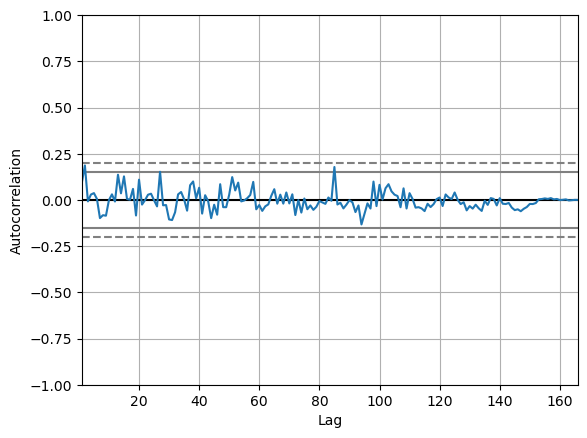

For New York


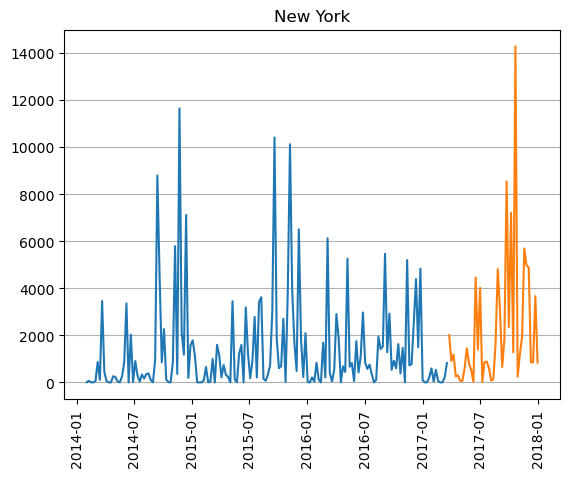

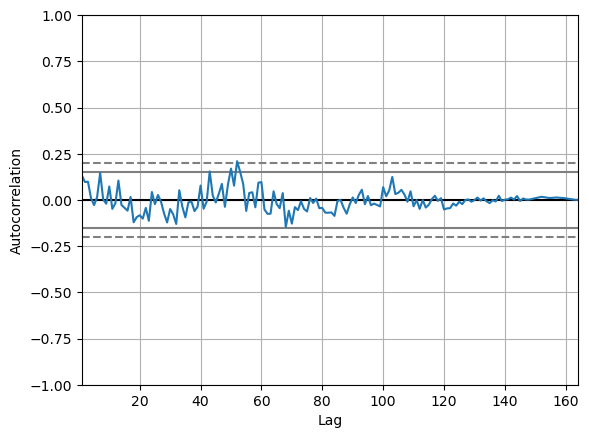

For Texas


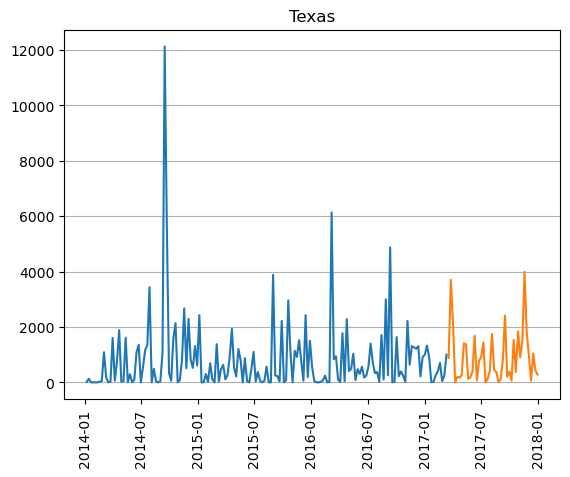

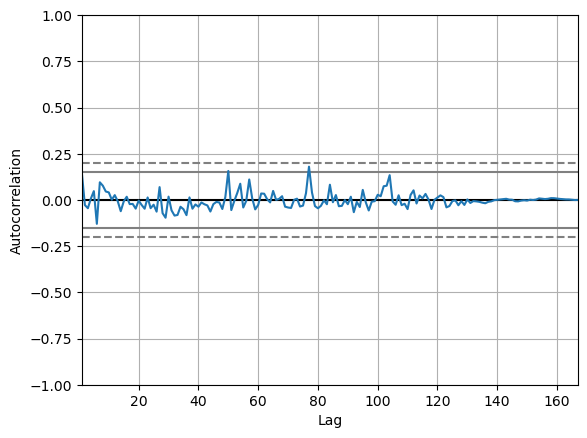

For Washington


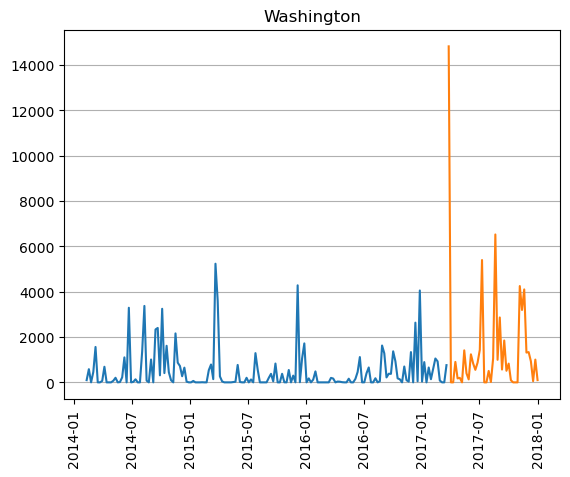

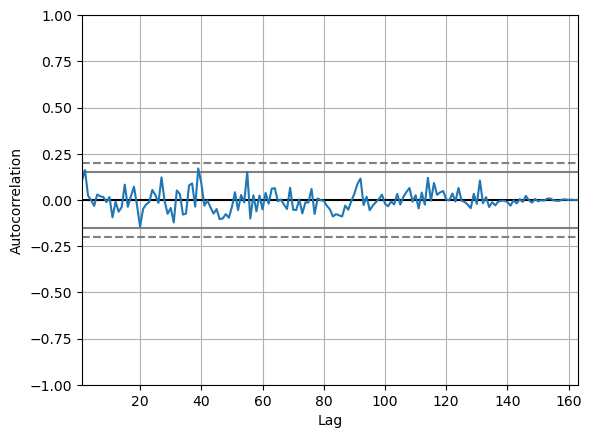

In [271]:
states_list = ['California', 'New York', 'Texas', 'Washington']
print('Scanning for autocorrelation on a weekly timescale\n')

for state in states_list:    
    state= state
    print(f'For {state}')
    df = wrangle.wrangle_superstore()
    df = df[df.state== state]
    df = pd.DataFrame(df.resample('W').sales.agg('sum'))
    train, test = time_split_superstore(df, state)
    pd.plotting.autocorrelation_plot(train.sales)
    plt.show()

## Observations:
- California may be modelable after outliers are handled but too much data may be lost when 80 weeks of nulls are dropped
- New York may be modelable on this scale after nulls are handled
- Texas is probably not modelable on this timescale
- Washington may be modelable on this timescale once outliers are handled

Findings: New York sales seem to have seasonality when sampled monthly

## Hit list:
- Train
- 2014-11-23 -> 8000
- 2014-09-14 -> 6500
- 2015-09-20 -> 6500
- 2015-11-08 -> 7000

- Test
- 2017-10-22 -> 9000

In [187]:
def states_time_wrangle():    
    df = wrangle.wrangle_superstore()

    df_resampled = df[df.state == 'New York']

    df_resampled = pd.DataFrame(df_resampled.resample("W").sales.agg('sum'))
    
    df_resampled.sales.loc['2014-11-23'] = 8000
    df_resampled.sales.loc['2014-09-14'] = 6500
    df_resampled.sales.loc['2015-09-20'] = 6500
    df_resampled.sales.loc['2015-11-08'] = 7000
    df_resampled.sales.loc['2017-10-22'] = 9000
    
    df_resampled['lag_53'] = df_resampled.sales.shift(53)
    df_resampled = df_resampled.dropna()

    train_size = int(len(df_resampled) * .8)
    validate_size = int(len(df_resampled) * .1)
    test_size = int(len(df_resampled) - train_size - validate_size)
    validate_end_index = train_size + validate_size

    # split into train, validation, test
    train = pd.DataFrame(df_resampled[: train_size])
    validate = pd.DataFrame(df_resampled[train_size : validate_end_index])
    test = pd.DataFrame(df_resampled[validate_end_index : ])
    
    print(f'''
train length: {train.shape[0]}
validate length: {validate.shape[0]}
test length: {test.shape[0]}
    ''')
    
    return train, validate, test

In [188]:
train, validate, test = time_wrangle()


train length: 121
validate length: 15
test length: 16
    


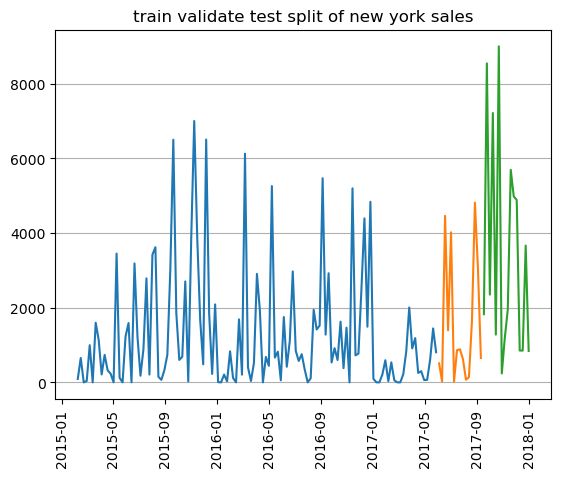

In [189]:
plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(test.sales)
plt.xticks(rotation=90);
plt.grid(axis='y')
plt.title('train validate test split of new york sales');

## Remove outliers and work outlier handling into the wrangle function

In [190]:
outliers = train[train.index < pd.to_datetime('2016-01-01')]

outliers.sales.sort_values(ascending=False).head()

date
2015-11-08    7000.000
2015-12-06    6504.506
2015-09-20    6500.000
2015-11-15    3885.554
2015-11-01    3876.278
Name: sales, dtype: float64

In [191]:
outliers = test[test.index > pd.to_datetime('2017-08-01')]

outliers.sales.sort_values(ascending=False).head()

date
2017-10-22    9000.000
2017-09-24    8544.824
2017-10-08    7214.738
2017-11-19    5691.602
2017-11-26    4980.382
Name: sales, dtype: float64

## Hit list (remove these outliers):
- Train
- 2014-11-23 -> 8000
- 2014-09-14 -> 6500
- 2015-09-20 -> 6500
- 2015-11-08 -> 7000

- Test
- 2017-10-22 -> 9000

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

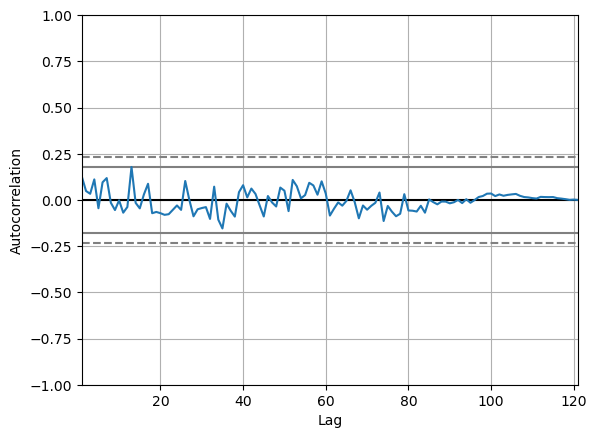

In [192]:
pd.plotting.autocorrelation_plot(train.sales)

New York sales approximately 52 weeks ago seem to predict current sales in the train data

Next Steps: Remove outliers in the data; Add a column of sales shifted by 52

In [193]:
train.head()

sales  lag_53
date                       
2015-02-08   90.882   3.928
2015-02-15  652.414  64.960
2015-02-22    0.000   0.000
2015-03-01   37.776   0.000
2015-03-08  995.787  53.700

## handle outliers:
- 2014-03-23 -> 15000
- 2014-09-14 -> 20000
- 2014-11-23 -> 22000

In [194]:
id_outliers.sort_values('sales', ascending=False).head(3)

Empty DataFrame
Columns: [sales, lag_53]
Index: []

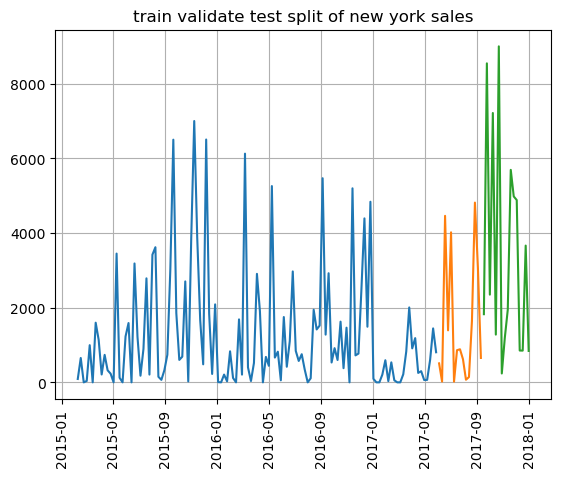

In [195]:
plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(test.sales)
plt.xticks(rotation=90);
plt.grid('x')
plt.title('train validate test split of new york sales');

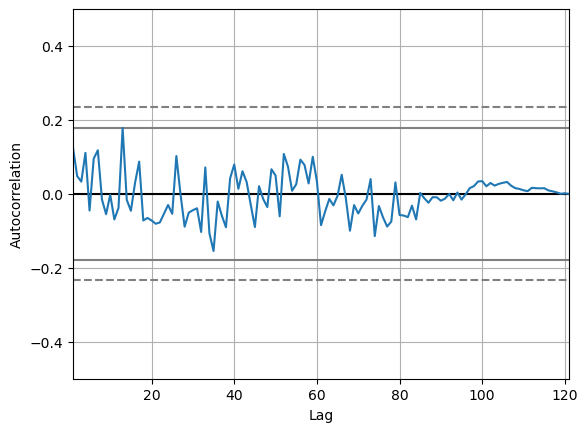

In [196]:
pd.plotting.autocorrelation_plot(train.sales)
plt.ylim(-0.5,0.5);

## Stats testing lag values

In [197]:
results_list = []

for i in range(50, 56):
    pearson = train.copy()  # Make a copy of 'train' DataFrame
    pearson[f'lag_{i}'] = pearson.sales.shift(i)
    pearson = pearson.dropna()
    r, p = pearsonr(pearson.sales, pearson[f'lag_{i}'])
    results_list.append({
        'lag': i,
        'R value': r,
        'P-value': p
    })

results_df = pd.DataFrame(results_list)
display(results_df)


lag   R value   P-value
0   50  0.090681  0.452001
1   51 -0.100601  0.407308
2   52  0.192187  0.113640
3   53  0.133685  0.277105
4   54  0.018442  0.882241
5   55  0.050394  0.687806

## Findings:
- A lag of 53 weeks is the most highly correlated to the target (R = .51) and is statistically significant (P-value = 0.000025)

## Next step:
- Add a lag column of 53 to the train dataframe and drop nulls

In [198]:
# Create and append a column with a lag of 53 weeks to the train dataframe and drop the nulls
train['lag_52'] = train.sales.shift(52)
train = train[['sales', 'lag_52']]
train = train.dropna()
train

sales    lag_52
date                          
2016-02-07   117.960    90.882
2016-02-14     0.000   652.414
2016-02-21  1686.568     0.000
2016-02-28   207.360    37.776
2016-03-06  6125.822   995.787
...              ...       ...
2017-04-30    62.960   442.358
2017-05-07    65.880  5257.312
2017-05-14   606.470   663.756
2017-05-21  1444.918   821.224
2017-05-28   806.050    54.900

[69 rows x 2 columns]

## Successfully added the lag_53 column to the train dataframe.
## Next Step: Create baseline models.

#
# Modeling

In [199]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var])**.5 ), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])


In [200]:
# take the last item of sales total and assign to variable
last_sale = train['sales'][-1:][0]

yhat_df = pd.DataFrame(
    {'sales': [last_sale]},
    index=validate.index)

yhat_df.shape


(15, 1)

sales -- RMSE: 1794


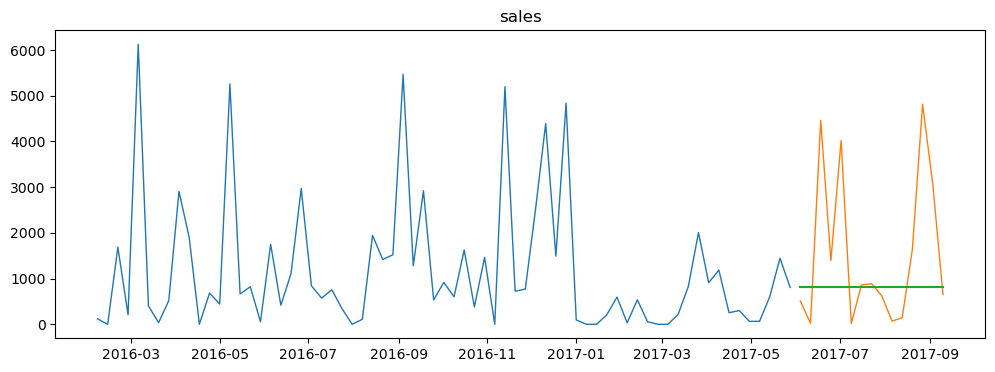

In [201]:
# Plot the last observed model value
for col in train[['sales']].columns:
    plot_and_eval(col)

In [202]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales'].mean(), 2)

yhat_df = pd.DataFrame({'sales': [avg_sales]},
                        index=validate.index)


for col in train[['sales']].columns:
    plot_and_eval(col)

sales
date               
2017-06-04  1172.25
2017-06-11  1172.25
2017-06-18  1172.25
2017-06-25  1172.25
2017-07-02  1172.25

In [204]:
train.shape

(69, 2)

Period = 40 weeks

sales -- RMSE: 1677


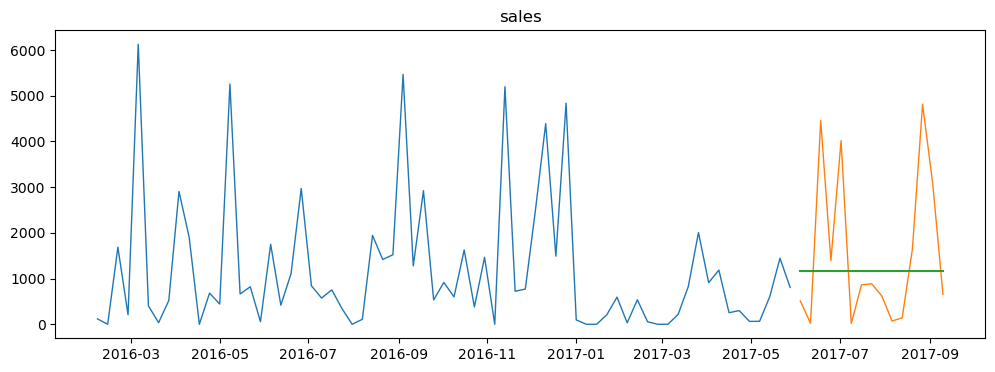

Period = 41 weeks

sales -- RMSE: 1676


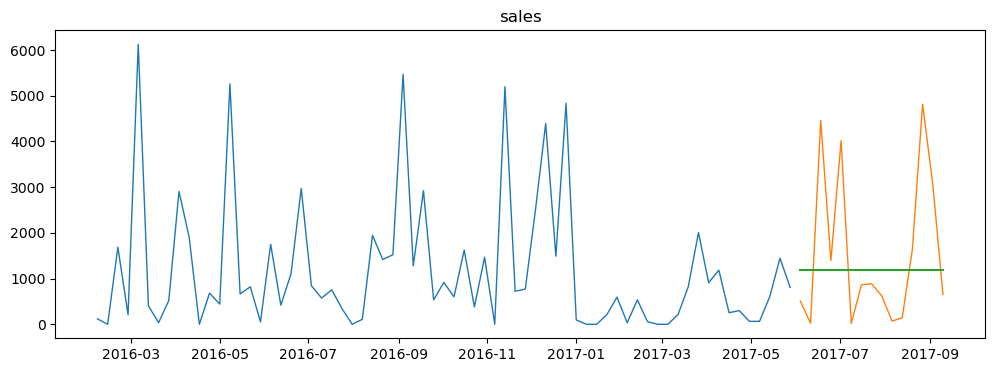

Period = 42 weeks

sales -- RMSE: 1672


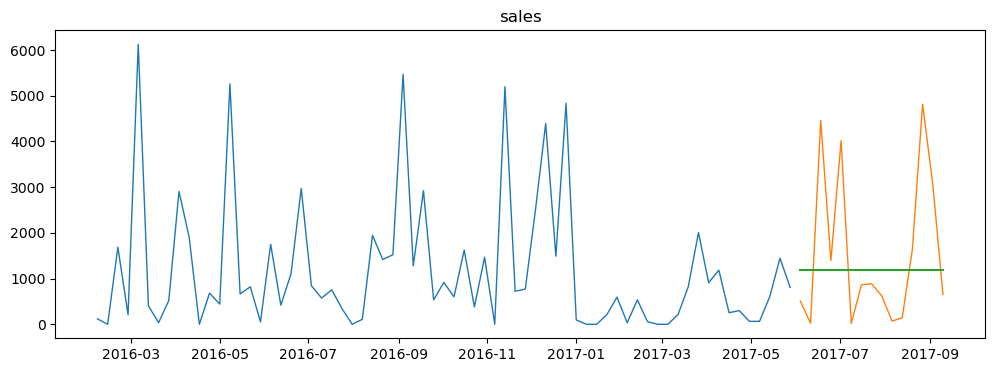

Period = 43 weeks

sales -- RMSE: 1677


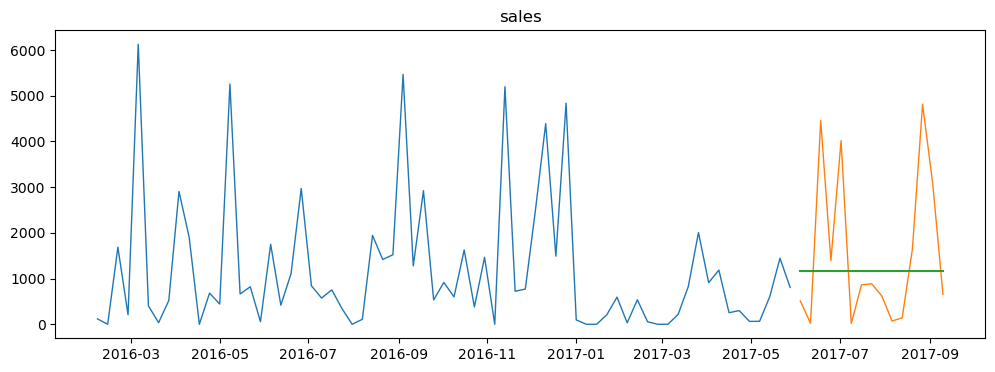

Period = 44 weeks

sales -- RMSE: 1683


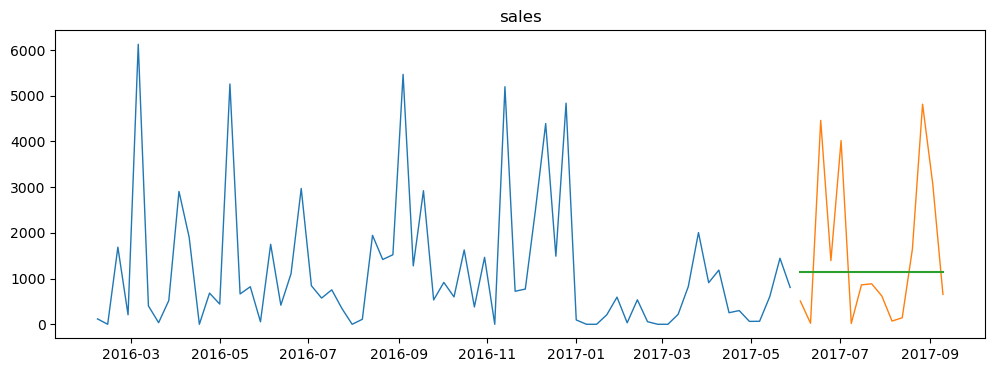

Period = 45 weeks

sales -- RMSE: 1688


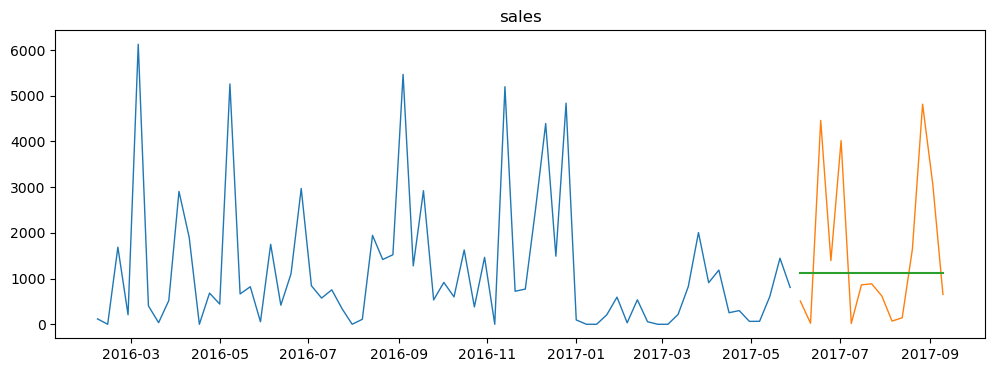

Period = 46 weeks

sales -- RMSE: 1690


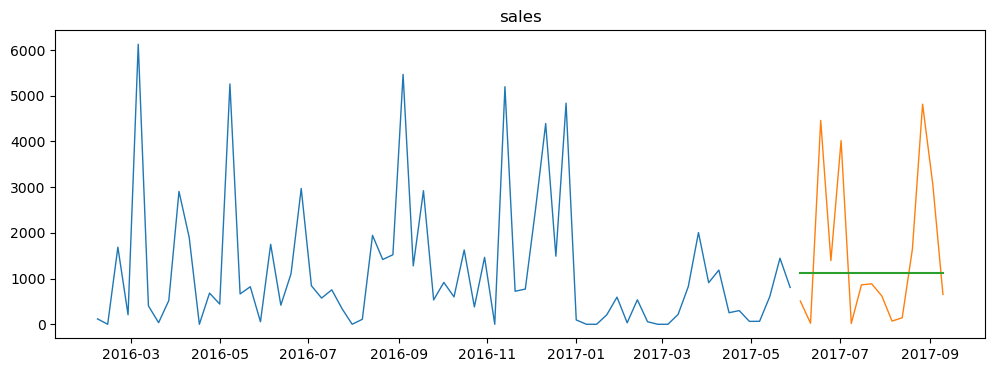

Period = 47 weeks

sales -- RMSE: 1693


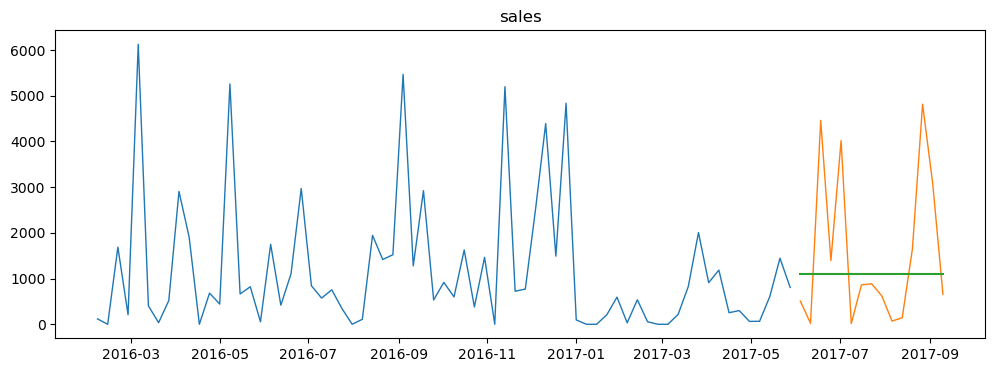

Period = 48 weeks

sales -- RMSE: 1694


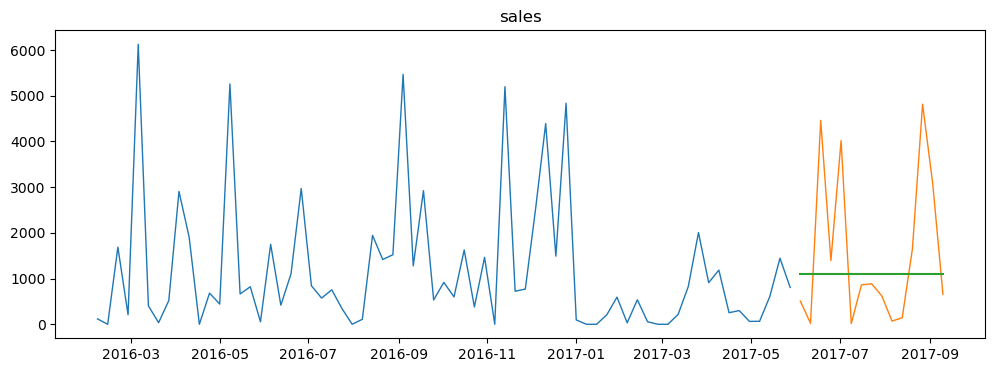

Period = 49 weeks

sales -- RMSE: 1685


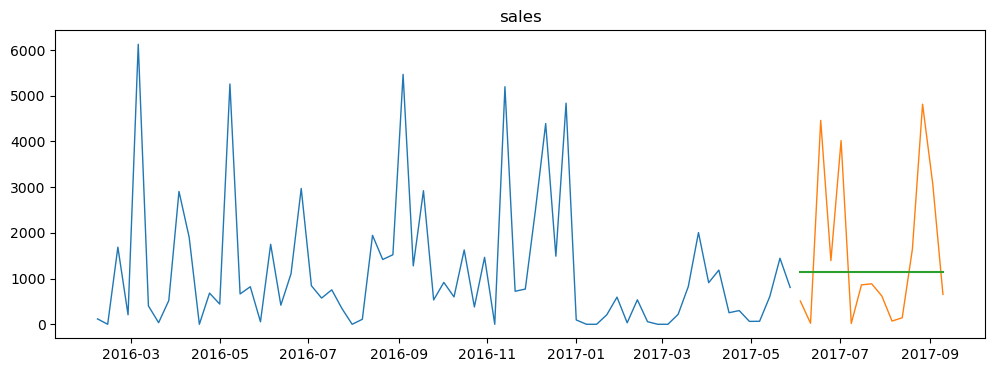

Period = 50 weeks

sales -- RMSE: 1685


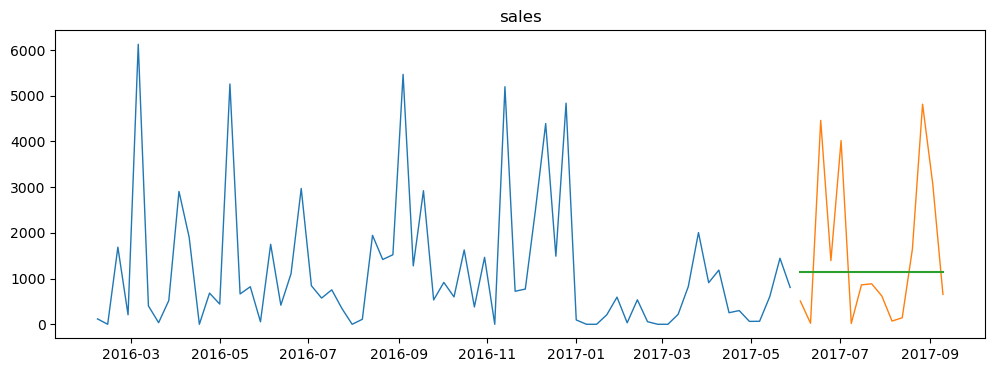

Period = 51 weeks

sales -- RMSE: 1688


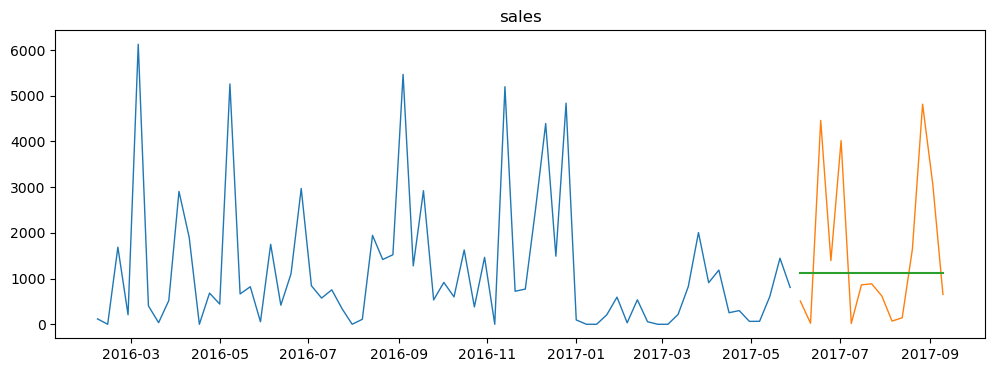

Period = 52 weeks

sales -- RMSE: 1685


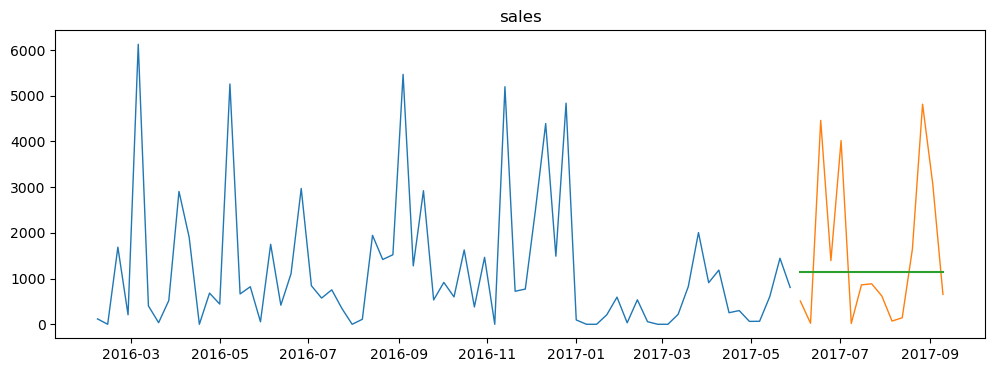

Period = 53 weeks

sales -- RMSE: 1690


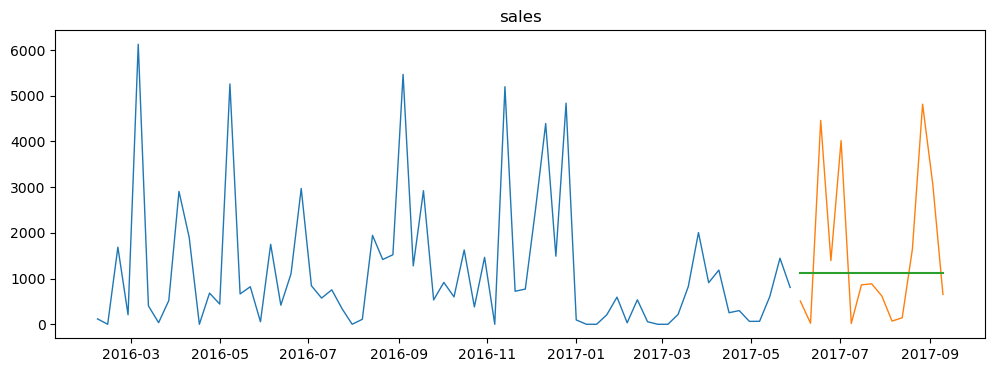

Period = 54 weeks

sales -- RMSE: 1692


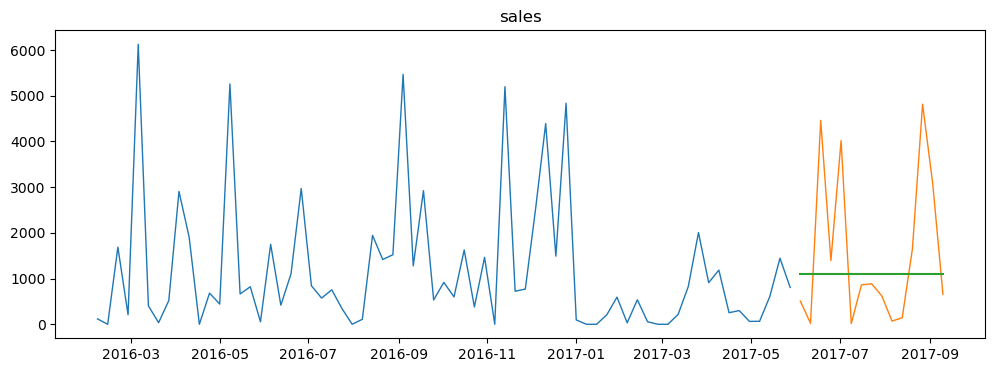

Period = 55 weeks

sales -- RMSE: 1694


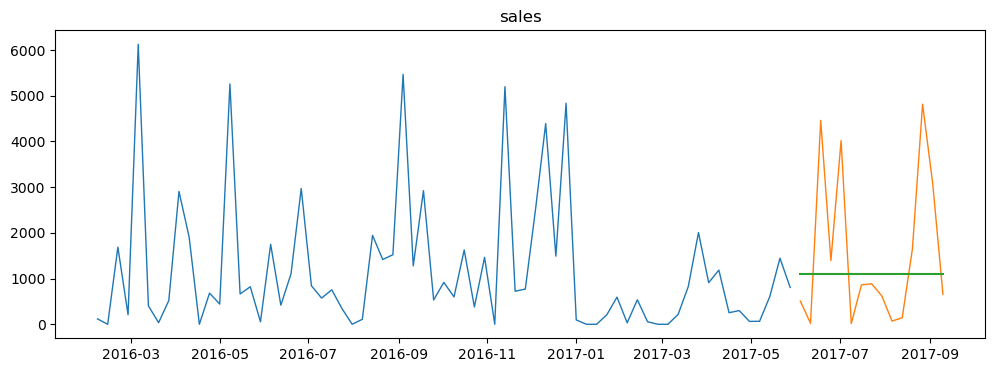

In [205]:
# compute a weekly rolling average, 
# use the most recent/last 30 weekly period value to predict forward. 

for i in range(40,56):
    period = i

    rolling_sales = round(train['sales'].rolling(period).mean()[-1], 2)

    # yhat_df = make_predictions()

    yhat_df = pd.DataFrame({'sales': rolling_sales},
                             index=validate.index)
    # Plot 30 week rolling average

    for col in train[['sales']].columns:
        print(f'Period = {period} weeks\n')
        plot_and_eval(col)
        

## Findings: 
- 52 week rolling average had the lowest baseline RMSE of 4975 

## Next steps:
- Build a Holt's linear, Holt's seasonal, and LinearRegression model and evaluate the RMSE

In [206]:
# Resample 'train' to weekly data and calculate the mean
weekly_mean = train.sales.resample('W').mean()

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(weekly_mean)

# Plot each component separately
decomposition.plot()

for col in train[['sales']].columns:
    model = Holt(train[col], exponential=False, damped=False)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


for col in train[['sales']].columns:
    plot_and_eval(target_var = col)

ValueError: x must have 2 complete cycles requires 104 observations. x only has 69 observation(s)

## Findings: 
- The Holt's linear model does not beat the 52 week rolling average baseline

## Holt's seasonal model

In [209]:
# Make/fit the models for sales
hst_sales_fit1 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='add').fit()
hst_sales_fit2 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='mul').fit()
hst_sales_fit3 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='add', damped=True).fit()
hst_sales_fit4 = ExponentialSmoothing(train.sales, seasonal_periods=52, trend='add', seasonal='mul', damped=True).fit()

results_sales=pd.DataFrame({'model':['hst_sales_fit1', 'hst_sales_fit2', 'hst_sales_fit3', 'hst_sales_fit4'],
                              'SSE':[hst_sales_fit1.sse, hst_sales_fit2.sse, hst_sales_fit3.sse, hst_sales_fit4.sse]})
results_sales.sort_values(by='SSE')


ValueError: Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data.

In [211]:
yhat_df = pd.DataFrame({'sales': hst_sales_fit4.forecast(validate.shape[0] + 1)},
                          index=validate.index)

for col in train[['sales']].columns:
    plot_and_eval(col)

NameError: name 'hst_sales_fit4' is not defined

## Findings:
- The Holt's seasonal trend model did not outperform the baseline model

## Linear Regression


In [213]:
train, validate, test = time_wrangle()


train length: 121
validate length: 15
test length: 16
    


In [214]:
train

sales    lag_53
date                          
2015-02-08    90.882     3.928
2015-02-15   652.414    64.960
2015-02-22     0.000     0.000
2015-03-01    37.776     0.000
2015-03-08   995.787    53.700
...              ...       ...
2017-04-30    62.960   681.880
2017-05-07    65.880   442.358
2017-05-14   606.470  5257.312
2017-05-21  1444.918   663.756
2017-05-28   806.050   821.224

[121 rows x 2 columns]

In [215]:
#x-y split the dataframes
X_train, y_train = pd.DataFrame(train.lag_53), pd.DataFrame(train.sales)
X_validate, y_validate = pd.DataFrame(validate.lag_53), pd.DataFrame(validate.sales)
X_test, y_test = pd.DataFrame(test.lag_53), pd.DataFrame(test.sales)

In [216]:
# Make the thing
model = LinearRegression()

# Fit the thing
ny_model = model.fit(X_train, y_train)

# Make Predictions
y_hat_val = ny_model.predict(X_validate)
y_hat_test = ny_model.predict(X_test)
# Graph predictions


y_hat_val = pd.DataFrame(y_hat_val)
y_hat_test = pd.DataFrame(y_hat_test)

y_hat_val.index = validate.index
y_hat_test.index = test.index

plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(y_hat_val)
plt.xticks(rotation=90);

In [221]:
train_rmse = mean_squared_error(y_train, model.predict(X_train))**.5
print(f'The train regression RMSE is {round(train_rmse)}')

The train regression RMSE is 1578


In [226]:
validate_rmse = mean_squared_error(y_validate, model.predict(X_validate))**.5

print(f'The validate regression RMSE is {round(validate_rmse)}')

The validate regression RMSE is 1638


In [227]:
test_rmse = mean_squared_error(y_test, model.predict(X_test))**.5

print(f'The test regression RMSE is {round(test_rmse)}')

The test regression RMSE is 3517


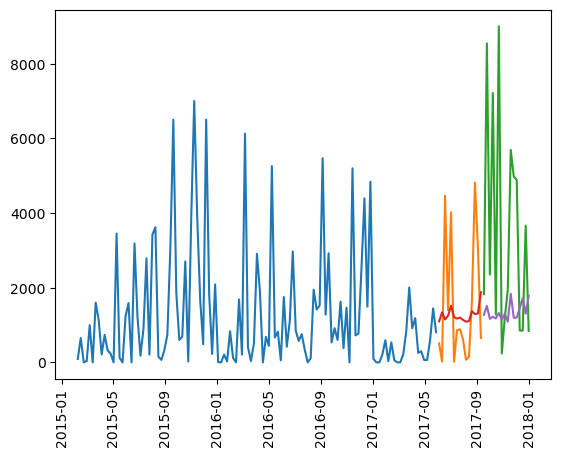

In [228]:
plt.plot(train.sales)
plt.plot(validate.sales)
plt.plot(test.sales)
plt.plot(y_hat_val)
plt.plot(y_hat_test)
plt.xticks(rotation=90);

In [229]:
test.shape

(16, 2)

#### Findings:
#### Neither profit or sales have an autocorrelation. This project will have to rely on regression analysis from this point on #####

In [230]:
df.product_id.nunique()

1862

In [231]:
df.groupby('segment').agg('mean').sales.mean()

232.84299491109832

segment group sales stats


segment      Consumer     Corporate   Home Office
count     5191.000000   3020.000000   1783.000000
mean       223.733644    233.823300    240.972041
std        585.516175    599.410408    755.516379
min          0.444000      0.556000      0.990000
25%         17.264000     17.469000     17.045000
50%         53.720000     56.540000     52.440000
75%        206.106000    212.895000    210.906000
max      13999.960000  17499.950000  22638.480000

segment group sales averages


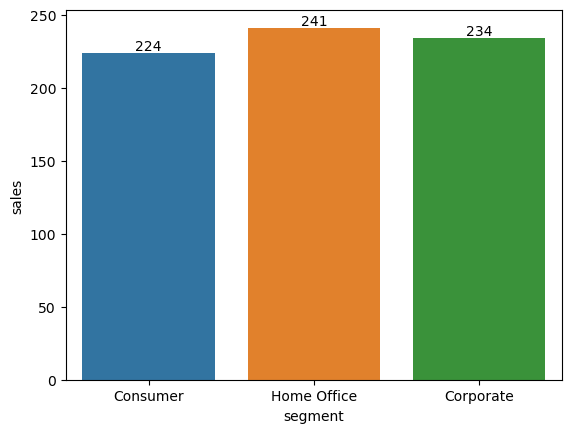

segment group sales distributions


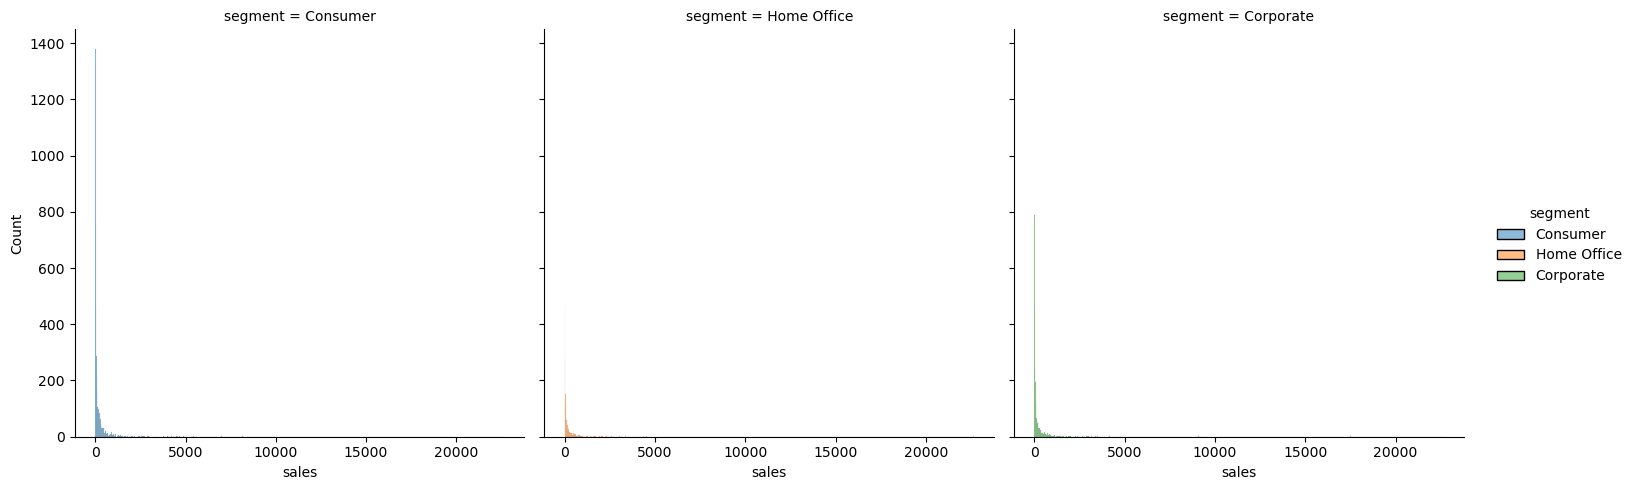

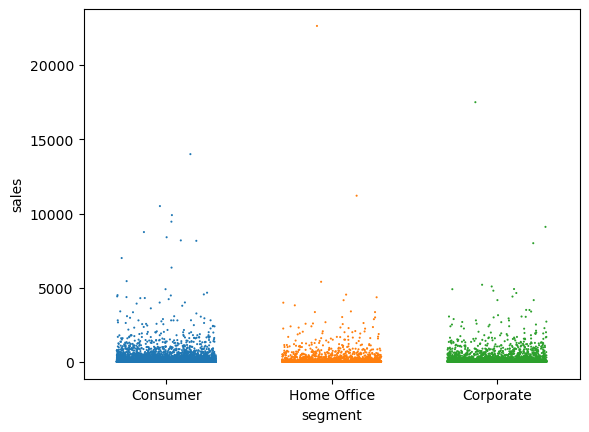

segment group sales boxplots


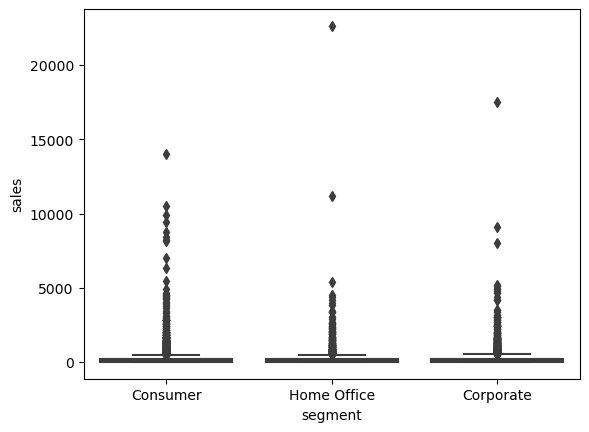

state group sales stats


state      Alabama      Arizona     Arkansas   California     Colorado  \
count    61.000000   224.000000    60.000000  2001.000000   182.000000   
mean    319.846557   157.508933   194.635500   228.729451   176.418231   
std     545.761807   249.710692   316.405669   491.005264   324.415072   
min       3.620000     1.408000     4.300000     0.990000     1.080000   
25%      19.560000    15.164000    19.777500    19.760000    15.160000   
50%      70.980000    61.512000    54.420000    61.020000    51.016000   
75%     358.580000   201.984000   209.837500   225.296000   175.418000   
max    3040.000000  1879.960000  1793.980000  8187.650000  2549.985000   

state  Connecticut      Delaware  District of Columbia       Florida  \
count    82.000000     96.000000             10.000000    383.000000   
mean    163.223866    285.948635            286.502000    233.612815   
std     251.732268   1112.818485            547.419707   1205.490630   
min       3.520000      3.380000              9.640000      1.167000   
25%      14.712500     19.950000             20.265000     11.952000   
50%      50.000000     67.005000             35.800000     41.472000   
75%     181.911750    202.867000             41.047500    182.832000   
max    1133.350000  10499.970000           1379.920000  22638.480000   

state      Georgia  ...  South Dakota    Tennessee        Texas         Utah  \
count   184.000000  ...      12.00000   183.000000   985.000000    53.000000   
mean    266.825217  ...     109.63000   167.551219   172.779742   211.699170   
std     637.796228  ...     148.25714   360.678518   424.447771   378.723382   
min       1.780000  ...       2.97000     1.584000     0.444000     4.960000   
25%      19.230000  ...      13.63500    12.228000    10.824000    21.360000   
50%      70.955000  ...      34.25000    42.048000    36.288000    60.120000   
75%     250.440000  ...     152.20500   122.024000   158.376000   158.900000   
max    6354.950000  ...     416.32000  2314.116000  8159.952000  1499.950000   

state      Vermont     Virginia    Washington  West Virginia    Wisconsin  \
count    11.000000   224.000000    506.000000       4.000000   110.000000   
mean    811.760909   315.342500    273.994605     302.456000   291.951000   
std    1309.310745   792.001296    777.244483     313.508627   461.590111   
min       2.040000     2.840000      1.344000       6.240000     1.810000   
25%      46.100000    27.495000     20.663500      63.360000    25.635000   
50%     205.030000    65.250000     65.940000     265.120000    93.860000   
75%    1004.975000   251.632500    209.835000     504.216000   381.607500   
max    4404.900000  8749.950000  13999.960000     673.344000  2807.840000   

state   Wyoming  
count     1.000  
mean   1603.136  
std         NaN  
min    1603.136  
25%    1603.136  
50%    1603.136  
75%    1603.136  
max    1603.136  

[8 rows x 49 columns]

state group sales averages


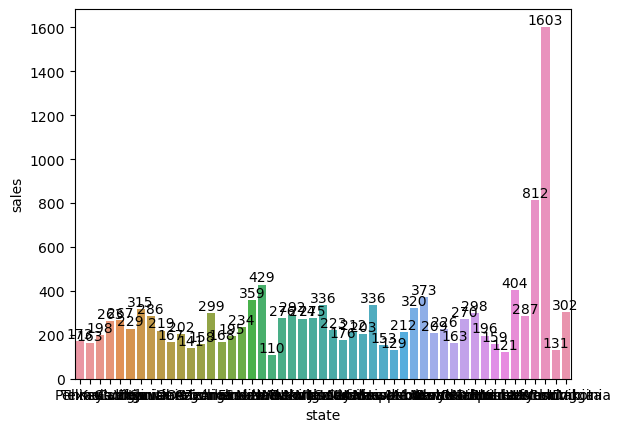

state group sales distributions


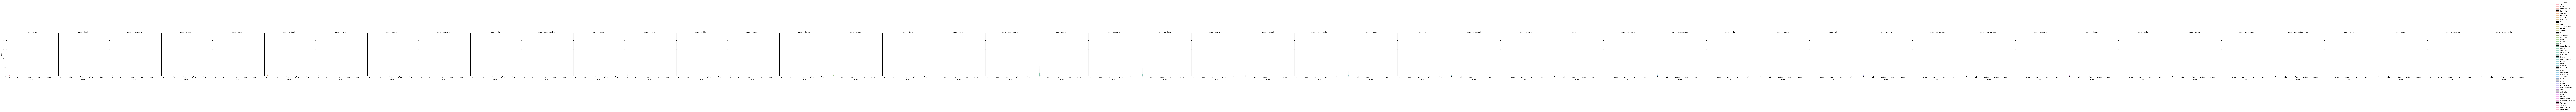

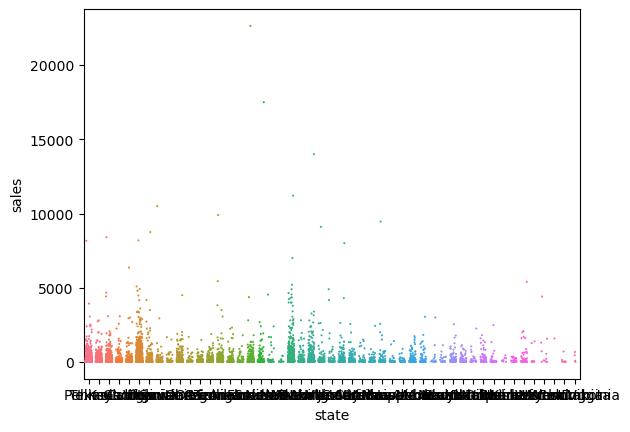

state group sales boxplots


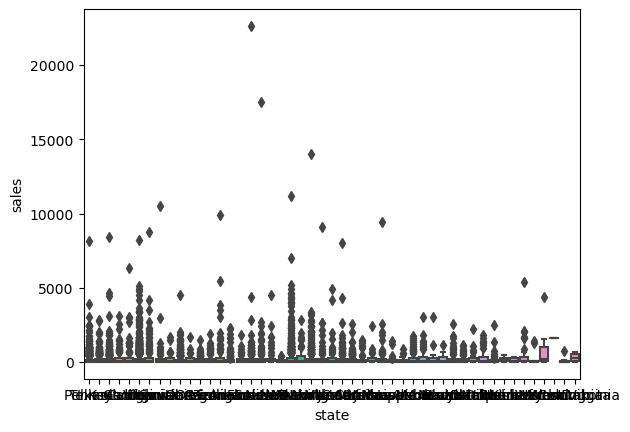

region group sales stats


region       Central          East         South          West
count    2323.000000   2848.000000   1620.000000   3203.000000
mean      215.772661    238.336110    241.803645    226.493233
std       632.779010    620.712652    774.796273    524.876877
min         0.444000      0.852000      1.167000      0.990000
25%        14.620000     17.520000     17.187000     19.440000
50%        45.980000     54.900000     54.594000     60.840000
75%       200.012000    209.617500    208.722000    215.809000
max     17499.950000  11199.968000  22638.480000  13999.960000

region group sales averages


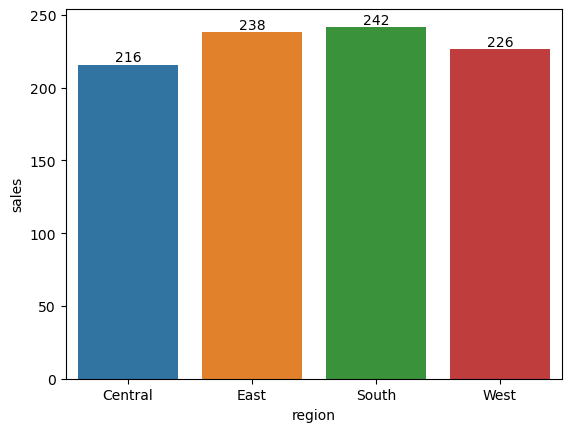

region group sales distributions


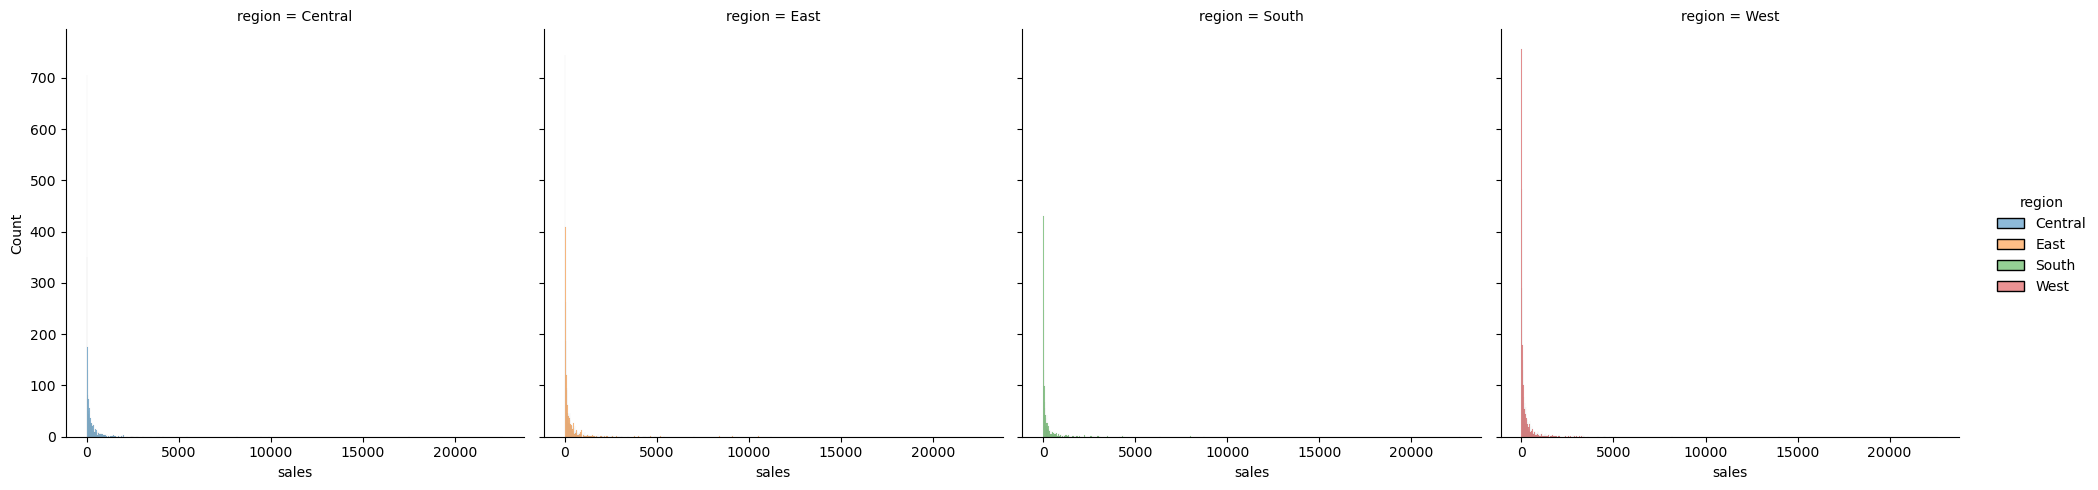

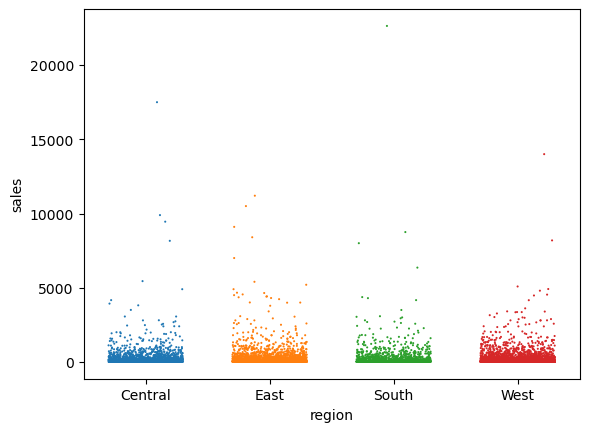

region group sales boxplots


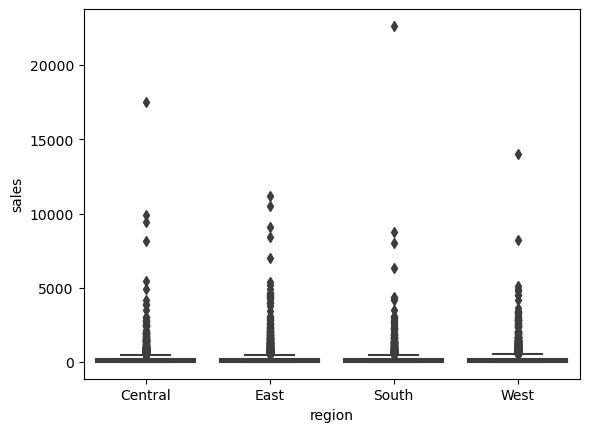

category group sales stats


category    Furniture  Office Supplies    Technology
count     2121.000000      6026.000000   1847.000000
mean       349.834887       119.324101    452.709276
std        503.179145       382.182228   1108.655848
min          1.892000         0.444000      0.990000
25%         47.040000        11.760000     68.016000
50%        182.220000        27.418000    166.160000
75%        435.168000        79.920000    448.534000
max       4416.174000      9892.740000  22638.480000

category group sales averages


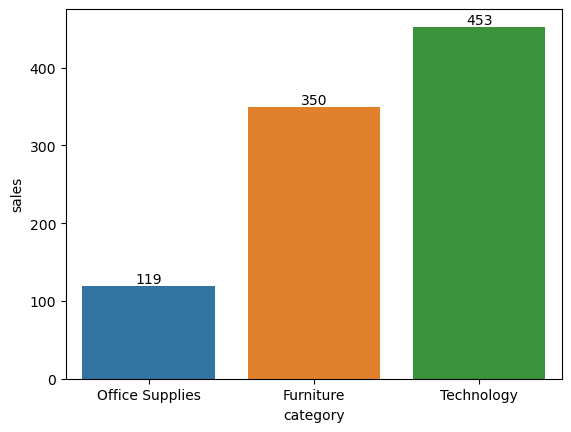

category group sales distributions


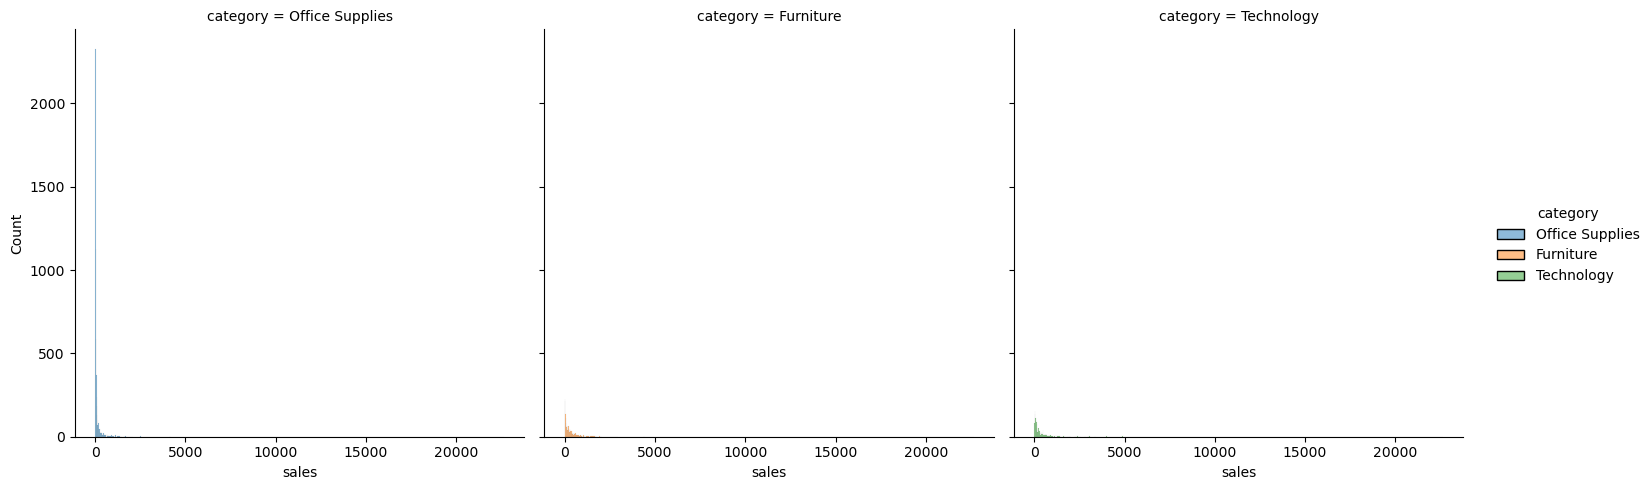

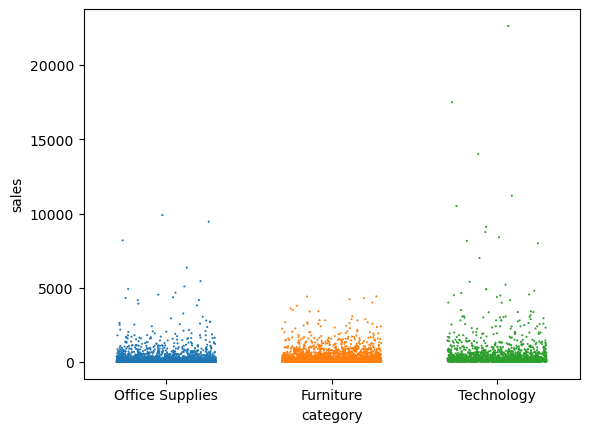

category group sales boxplots


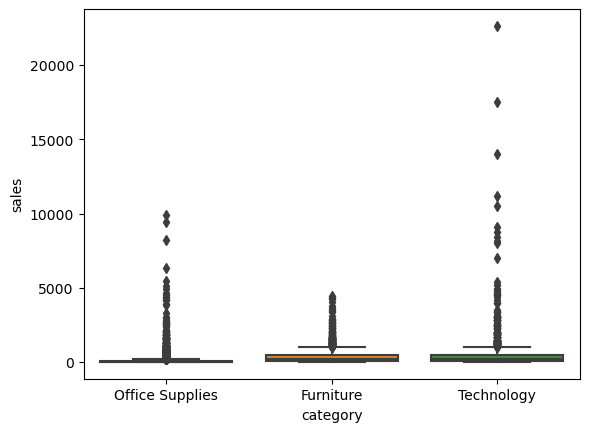

In [232]:
e.explore_bivariate_cat_to_cont_target(df,'sales', cat_cols=['segment', 'state', 'region', 'category'])


In [ ]:
# investigate state relationships with sales
df.groupby('region').agg('sum').sort_values('sales', ascending=False)

In [ ]:
dums = pd.get_dummies(df.region)
dums

In [ ]:
dums['sales'] = df.sales

In [ ]:
# investigate state relationships with sales
df.groupby('state').agg('sum').sort_values('sales',ascending=False)

In [ ]:
# Make a column that represents the aggregated values of feature columns over the last three months

In [ ]:
df.head()

## Observations:
- As sales increases, profits go up (duh)
- As sales increase, discounts go down
- As discounts increase, profits go down.

Sales across categories in highest selling states (in training data):
- California: uniform
- New York: furniture 60k furniture - office supplies 68k - technology 75k
- Texas: furniture 50k furniture - office supplies 30k - technology 50k
- Washington: 35k furniture - office supplies 28k - technology 40k

- New York buys the least in furniture, slightly more in office supplies and the most in technology.
- Texas and Washington buy about the same in furniture and technology around 25% less in office supplies.

- There may be higher competition in the office supplies market in Texas and Washington
- There may be higher competition in the furniture market in New York